# **StarCLIP**

> **Preamble:**  
> We develop **StarCLIP**, a self-supervised neural network model that embeds both APOGEE and JWST/NIRSpec data into a shared, physically meaningful latent space. We also develop **MockStarCLIP**, its a variant trained on semi-empirical, stochastically transformed JWST/NIRSpec spectra to simulate realistic observational effects. Learned embeddings from both models can then be used — without any model fine-tuning — for a variety of downstream tasks, including:  
> 1. Accurate in-modality and cross-modality semantic similarity search  
> 2. Stellar property estimation  
> 3. Non-linear dimensionality reduction
> *N.B.* In connection with the paper, datasets labeled in this code correspond to:
> - `JWST` (abbreviated `j`) → $\mathcal{J}$
> - `APOGEE` (abbreviated `a`) → $\mathcal{A}$
> - `Augmented JWST` (abbreviated `aug_jwst`) → $\mathcal{J}'$
> - `Augmented APOGEE` (abbreviated `aug_apogee`) → $\mathcal{A}'$
> - `Mock` (abbreviated `mock`) → $\mathcal{J}'_{\text{m}}$
> - `Extended Mock` (abbreviated `extended_mock`) → $\mathcal{J}'_{\text{e-m}}$

## Table of contents<font><a class='anchor' id='top'></a>
* ### [0. Set Up](#set-up) ###
* ### [1. Process Data](#process-data) ###
  * #### [1.1. Load Data](#load-data) ####
  * #### [1.2. Prepare Data](#prep-data) ####
  * #### [1.3. Emulate Real Data](#emul-real) #### 
  * #### [1.4. Partition Data](#partition-data) ####
* ### [2. Build Model](#build-model) ###
  * #### [2.1. Set up](#set-up-model) ####
  * #### [2.2. Create Embedders](#create-embedders) ####
  * #### [2.3. Create CLIP](#create-CLIP) ####
* ### [3. Train Model](#train-model) ###
  * #### [3.1. Set up](#set-up-train) ####
  * #### [3.2. Run training](#run-train) ####
* ### [4. Test Model](#test-model) ###
* ### [5. Implement Mock Model](#mock-model) ###
  * #### [5.1. Build Mock Model](#build-mock) ####
  * #### [5.2. Train Mock Model](#train-mock) ####
  * #### [5.3. Test Mock Model](#test-mock) ####
* ### [6. Transfer to Downstream Tasks](#downstream-tasks) ###
  * #### [6.1. Test Neighbourhood Retrieval](#css) ####
  * #### [6.2. Stellar Property Recovery](#stellar-property) ####
  * #### [6.3. Latent Space Visualisation](#latent-space) ####
* ### [7. References](#refs) ###

## **0. Set Up** <a class="anchor" id="set-up"></a>
We load all packages, set the parameters for plotting and define the seeding function. 

In [1]:
## Import packages ##
# Standard library
import os
import pickle
import random
import time
import warnings
from collections import defaultdict
from pathlib import Path
import psutil

# Numerical and data analysis
import numpy as np
import pandas as pd

# Visualization
import itertools
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

# Signal processing and astronomy
import cv2
from astropy import constants, units
from astropy.io import fits
from scipy.stats import uniform

# Machine learning and data processing
import umap
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score, pairwise)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# PyTorch and Lightning
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import (ConcatDataset, DataLoader, Dataset, Subset, TensorDataset)
from torchsummary import summary

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

2025-04-08 13:38:04.971073: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-08 13:38:07.882845: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# ## Get info about GPU ## 
# !nvidia-smi
# print(f"Memory Usage: {psutil.virtual_memory().percent}%")
# print(f"CPU Usage: {psutil.cpu_percent(interval=1)}%")

In [3]:
## Set parameters for plotting ## 
plt.rcParams.update({
    'axes.facecolor': 'white',
    'axes.grid': False,
    'text.usetex': True,
    'font.family': 'serif'
})

# Set color map
cmap = sns.cubehelix_palette(8, start=2.8, rot=0.1, dark=0, light=0.95, as_cmap=True)

# Set label names
label_names = [
    r'$T_{\mathrm{eff}}$', r'$\log(g)$', r'[C/H]', r'[N/H]', r'[O/H]', r'[Na/H]', r'[Mg/H]', r'[Al/H]', r'[Si/H]', 
    r'[S/H]', r'[K/H]', r'[Ca/H]', r'[Ti/H]', r'[V/H]', r'[Cr/H]', r'[Mn/H]', r'[Fe/H]', r'[Co/H]', r'[Ni/H]', r'[Ce/H]'
]

In [4]:
## Set up seed for reproducibility ## 
def set_seed(seed):
    """
    Sets the random seed across multiple libraries to ensure reproducibility in experiments.

    This function fixes randomness in PyTorch, CUDA, NumPy, and PyTorch Lightning, ensuring
    that results are consistent across multiple runs of the same code.

    Parameters:
    -----------
    seed : int
        The seed value to be used for random number generators.
    """
    torch.cuda.manual_seed(seed) # sets the seed for PyTorch's CUDA operations
    torch.backends.cudnn.deterministic = True # configures cuDNN to enforce deterministic computations
    torch.backends.cudnn.benchmark = False # disables cuDNN benchmarking to prevent non-deterministic behaviour
    L.seed_everything(seed) # sets global seed for PyTorch Lightning 
    np.random.seed(seed) # sets seed for NumPy’s random number generator.

## **1. Process Data** <a class="anchor" id="process-data"></a>
We clean the data, remove duplicates and define a pipeline to mock up data. We then split the datasets into train, validation and test sets in a 5:1:2 ratio.

In [5]:
## Define directories ## 
DATA_DIR = Path('/yngve_data/')
LOCAL_DATA_DIR = Path('/geir_data/scr/sandford')

In [6]:
## Load in JWST files ## 
jwst_spec_file = LOCAL_DATA_DIR / 'JWST_APOGEE.h5'
jwst_wave = pd.read_hdf(jwst_spec_file, 'wavelength').iloc[0].values
jwst_labels = pd.read_hdf(jwst_spec_file, 'labels')
jwst_spectra = pd.read_hdf(jwst_spec_file, 'spectra')

In [7]:
## Load in APOGEE files ## 
apogee_spec_file = LOCAL_DATA_DIR / 'apogee_dr17.h5'
apogee_dr17_dir = DATA_DIR / 'sdss/apogee/dr17/apogee/spectro/aspcap/dr17/synspec'

_LOG10LAMBDA0 = 4.179
_DLOG10LAMBDA = 6. * 10.**-6.
_NLAMBDA = 8575
apogee_wave = 10.**np.arange(
    _LOG10LAMBDA0,
    _LOG10LAMBDA0 +_NLAMBDA * _DLOG10LAMBDA,
    _DLOG10LAMBDA
)
apogee_labels = pd.read_hdf(apogee_spec_file, 'allstar')
apogee_spectra = pd.read_pickle(os.path.join('DATA', 'apogee_spectra.pkl')) 

### **1.2. Prepare Data** <a class="anchor" id="prep-data"></a>

In [8]:
## Convert JWST row names from stellar tags to indices ## 
jwst_spectra.reset_index(drop=True, inplace=True)
jwst_labels.reset_index(drop=True, inplace=True) 

print(jwst_labels.index) # preview 

RangeIndex(start=0, stop=19799, step=1)


In [9]:
## Drop missing data point in APOGEE data with no JWST pair ## 
apogee_labels.drop(index=11215, inplace=True)
apogee_labels.reset_index(drop=True, inplace=True)

print(f"Shapes of JWST and APOGEE labels before dropping duplicates: {jwst_labels.shape}, {apogee_labels.shape}")

## Drop all duplicates in APOGEE and JWST data ## 
duplicate_indices = apogee_labels[apogee_labels.duplicated(subset='APOGEE_ID', keep='first')].index
apogee_labels.drop(index=duplicate_indices, inplace=True)
jwst_spectra.drop(index=duplicate_indices, inplace=True) 
jwst_labels.drop(index=duplicate_indices, inplace=True)

apogee_labels.reset_index(drop=True, inplace=True)
jwst_spectra.reset_index(drop=True, inplace=True) 
jwst_labels.reset_index(drop=True, inplace=True)

print(f"Shapes of JWST and APOGEE labels after dropping duplicates: {jwst_labels.shape}, {apogee_labels.shape}")

Shapes of JWST and APOGEE labels before dropping duplicates: (19799, 20), (19799, 55)
Shapes of JWST and APOGEE labels after dropping duplicates: (19001, 20), (19001, 55)


In [10]:
## Calculate error (ERR) of each stellar label ## 
# Select all error columns except M_H_ERR and ALPHA_M_ERR
err_columns = [col for col in apogee_labels.columns if col.endswith('_ERR') and col not in {'M_H_ERR', 'ALPHA_M_ERR'}]

# Apply error propagation (for metallicities) or unit conversion (for Teff) 
for col in err_columns:
    if col.endswith('FE_ERR'):
        # Propagate error: [X/H] = [X/Fe] + [Fe/H]
        apogee_labels[col] = np.sqrt(apogee_labels[col]**2 + apogee_labels['FE_H_ERR']**2)
    elif col == 'TEFF_ERR':
        # Convert from Kelvin to kilokelvin
        apogee_labels[col] /= 1000

# Compute mean error for each selected column
err_columns_mean = apogee_labels[err_columns].mean()
err_columns_mean

TEFF_ERR     0.006225
LOGG_ERR     0.024625
C_FE_ERR     0.015059
N_FE_ERR     0.016881
O_FE_ERR     0.014946
NA_FE_ERR    0.058193
MG_FE_ERR    0.015169
AL_FE_ERR    0.022134
SI_FE_ERR    0.016440
S_FE_ERR     0.043704
K_FE_ERR     0.039348
CA_FE_ERR    0.017324
TI_FE_ERR    0.020044
V_FE_ERR     0.058423
CR_FE_ERR    0.036914
MN_FE_ERR    0.018157
FE_H_ERR     0.008735
CO_FE_ERR    0.039559
NI_FE_ERR    0.015459
CE_FE_ERR    0.042324
dtype: float32

In [11]:
## Drop unneeded APOGEE labels ## 
apogee_labels = apogee_labels.rename(columns=lambda x: x.replace('_FE', '').capitalize())
apogee_labels = apogee_labels.iloc[:, 9:]  # drop first nine columns
apogee_labels = apogee_labels.loc[:, ~apogee_labels.columns.str.endswith('err')]
apogee_labels = apogee_labels.rename(columns=lambda x: x.replace('Logg', 'logg'))
apogee_labels = apogee_labels.drop(columns=["M_h", "Alpha_m", "Vmicro", "Vmacro"])
apogee_labels = apogee_labels.rename(columns=lambda x: x.replace('_h', ''))

## Rescale Teff ## 
apogee_labels["Teff"] = apogee_labels["Teff"]/1000 
jwst_labels["Teff"] = jwst_labels["Teff"]/1000 

In [12]:
## Convert APOGEE metallicities [X/Fe] to JWST metallicities [X/H] ## 
# Note: [X/Fe] + [Fe/H] = [X/H].
Fe_H = apogee_labels["Fe"]
for i in range(2, len(apogee_labels.columns)):
    if i != apogee_labels.columns.get_loc('Fe'): # Fe column is already of the form [Fe/H] 
        apogee_labels.iloc[:, i] += Fe_H

## Check! ## 
all(jwst_labels == apogee_labels) == True

True

### **1.3. Emulate Real Data** <a class="anchor" id="emul-real"></a>

#### **1.3.0. Set up** 

In [14]:
# ## Define function to compare original and modified spectra ##
# def plot_spectrum_comparison(original_spectra, modified_spectra, index, title="Spectrum Comparison"):
#     """
#     Plot a comparison between the original and modified spectra for a given index.

#     Parameters:
#     - original_spectra (DataFrame): DataFrame containing the original spectra.
#     - modified_spectra (DataFrame): DataFrame containing the modified spectra (e.g., noisy or masked).
#     - index (int): The index of the spectrum to plot.
#     - title (str): Title for the plot (default is "Spectrum Comparison").
#     """
#     plt.figure(figsize=(10, 6))
#     plt.plot(original_spectra.iloc[index], label="Original Spectrum", alpha=0.5)
#     plt.plot(modified_spectra.iloc[index], label="Noised-Up Spectrum", alpha=0.5)
#     plt.xlabel("Wavelength Index")
#     plt.ylabel("Intensity")
#     plt.title(f"{title} (Index {index})")
#     plt.legend()
#     plt.grid(True)
#     plt.show()

In [15]:
# ## Define function to sample indices ##
# def sample_fe_indices(jwst_labels, n_samples=1000, num_bins=25, random_seed=42, plot=False):
#     """
#     Sample indices to ensure [Fe/H] values are approximately uniformly distributed.

#     Parameters:
#     - jwst_labels (DataFrame): DataFrame containing the Fe values.
#     - n_samples (int): Number of samples needed.
#     - num_bins (int): Number of bins for uniform sampling.
#     - random_seed (int): Seed for random sampling to ensure reproducibility.
#     - plot (bool): If True, plots the histogram of the sampled distribution.

#     Returns:
#     - list: A list of sampled indices.
#     """
#     np.random.seed(random_seed)  # Set random seed for reproducibility

#     # Sort values of Fe and get corresponding indices
#     sorted_Fe_indices = jwst_labels["Fe"].sort_values().index

#     # Divide range into equal bins
#     Fe_bins = pd.cut(jwst_labels["Fe"], bins=num_bins)

#     # Initialize list for storing sampled indices
#     random_sample_idx = []

#     # Loop through each bin range and sample uniformly
#     for bin_range in Fe_bins.cat.categories:
#         # Find all indices in 'jwst_labels' that fall into the current bin range
#         bin_indices = jwst_labels[Fe_bins == bin_range].index

#         # Calculate the number of points to sample from this bin
#         samples_in_bin = int(n_samples / num_bins)

#         # Sample from the bin
#         if len(bin_indices) <= samples_in_bin:
#             random_sample_idx.extend(bin_indices)
#         else:
#             random_sample_idx.extend(np.random.choice(bin_indices, size=samples_in_bin, replace=False))

#     # If fewer than n_samples were collected, sample the remaining number from the entire dataset
#     if len(random_sample_idx) < n_samples:
#         remaining_samples_needed = n_samples - len(random_sample_idx)
#         remaining_indices = jwst_labels.index.difference(random_sample_idx)
#         additional_samples = np.random.choice(remaining_indices, size=remaining_samples_needed, replace=False)
#         random_sample_idx.extend(additional_samples)

#     # Optional: Plot the distribution of sampled indices
#     if plot:
#         sampled_Fe_bins = pd.cut(jwst_labels.loc[random_sample_idx, "Fe"], bins=num_bins)
        
#         plt.figure()
#         plt.hist(jwst_labels.loc[random_sample_idx, "Fe"], bins=num_bins, edgecolor='black', 
#                  color='cornflowerblue', alpha=0.5, density=True, label="Sampled Distribution")
#         plt.hist(jwst_labels["Fe"], bins=num_bins, edgecolor='black', alpha=0.5, 
#                  density=True, label="Original Distribution")

#         # Set x-axis labels as bin intervals (centered between ticks)
#         bin_edges = np.linspace(jwst_labels["Fe"].min(), jwst_labels["Fe"].max(), num_bins + 1)
#         bin_labels = [f"{round(edge, 2)}" for edge in bin_edges]

#         plt.xticks(ticks=bin_edges, labels=bin_labels, rotation=90)
#         plt.xlabel('[Fe/H]')
#         plt.ylabel('Density')
#         plt.title('Histogram of Randomly Sampled Indices by [Fe/H] Bins')
#         plt.legend()
#         plt.show()

#     return random_sample_idx

# random_sample_idx = sample_fe_indices(jwst_labels, n_samples=250+5000, num_bins=50, plot=True)

In [ ]:
## Define augmented data ##
num_aug = 5 # number of times we augment our dataset
aug_apogee_spectra = pd.DataFrame(np.repeat(apogee_spectra.values, num_aug, axis=0), columns=apogee_spectra.columns)
aug_apogee_labels = pd.DataFrame(np.repeat(apogee_labels.values, num_aug, axis=0), columns=apogee_labels.columns)

# aug_jwst_spectra0 = pd.DataFrame(np.repeat(jwst_spectra.values, num_aug, axis=0), columns=jwst_spectra.columns) # 0 indicates "data will be modified"
aug_jwst_labels = pd.DataFrame(np.repeat(jwst_labels.values, num_aug, axis=0), columns=jwst_labels.columns)

In [16]:
## Define subsampled data ##
#mock_jwst_spectra0 = jwst_spectra.iloc[random_sample_idx]
mock_jwst_labels = jwst_labels.iloc[random_sample_idx]

#extended_mock_jwst_spectra0 = jwst_spectra.iloc[random_sample_idx]
extended_mock_jwst_labels = jwst_labels.iloc[random_sample_idx]

#### **1.3.1. EXTENDED-MOCKING: Perform Fixed-Data Substitution**

In [17]:
## Replace data near Paschen wavelengths with template values ##
# Define constants
PASCHEN_WAVELENGTHS = [12821.6, 10941.1, 10052.1, 9548.6]  # Angstroms
NEIGHBORHOOD_SIZE = 10  

# Extract wavelength column indices
wavelengths = extended_mock_jwst_spectra0.columns.astype(float)
paschen_indices = [np.abs(wavelengths - w).argmin() for w in PASCHEN_WAVELENGTHS]

# Extract neighborhoods from the first spectrum
first_spectrum = extended_mock_jwst_spectra0.iloc[0]
neighborhoods = {
    idx: first_spectrum.iloc[max(0, idx - NEIGHBORHOOD_SIZE): min(idx + NEIGHBORHOOD_SIZE + 1, len(wavelengths))].values
    for idx in paschen_indices
}

# Copy spectra DataFrame for modifications
extended_mock_jwst_spectra1 = extended_mock_jwst_spectra0.copy()

# Replace neighborhoods in all spectra
for i in range(1, len(extended_mock_jwst_spectra0)):
    for idx, values in neighborhoods.items():
        start, end = max(0, idx - NEIGHBORHOOD_SIZE), min(idx + NEIGHBORHOOD_SIZE + 1, len(wavelengths))
        if len(values) == (end - start):  # Ensure dimensions match
            extended_mock_jwst_spectra1.iloc[i, start:end] = values

# Plot the first six spectra
fig, axes = plt.subplots(3, 2, figsize=(8, 10))
axes = axes.flatten()
for idx, ax in enumerate(axes[:6]): 
    ax.plot(wavelengths, extended_mock_jwst_spectra0.iloc[idx], label=f"Original Spectrum {idx}", alpha=0.7, 
            color="blue" if idx == 0 else "orange")
    for paschen_idx in paschen_indices:
        start, end = max(0, paschen_idx - NEIGHBORHOOD_SIZE), min(paschen_idx + NEIGHBORHOOD_SIZE + 1, len(wavelengths))
        ax.plot(wavelengths[start:end], extended_mock_jwst_spectra1.iloc[idx, start:end], color="red", linewidth=2, 
                label="Replaced Region" if paschen_idx == paschen_indices[0] else "")
    ax.set_title(f"Spectrum {idx}")
    ax.grid(True)
axes[0].legend(loc='upper right')
plt.tight_layout()
plt.show()

#### **1.3.2. EXTENDED-MOCKING: Perform Pixel Masking** 

In [18]:
## Define function to mask dead pixels ## 
def mask_hot_dead_pixels(spectra_df, mask_fraction=0.001):
    """
    Mask a fraction of pixels uniformly at random across each spectrum to simulate hot/dead pixels.

    Parameters:
    - spectra_df (DataFrame): A DataFrame containing spectra, with each row
      representing a sample and columns representing measurements at different wavelengths.
    - mask_fraction (float): The fraction of pixels to mask in each spectrum (default is 0.001 or 0.1%).

    Returns:
    - DataFrame: A modified spectra DataFrame with randomly masked pixels (set to 1).
    """
    # Copy the spectra DataFrame to avoid modifying the original
    masked_spectra_df = spectra_df.copy()

    # Determine the number of pixels to mask for each spectrum
    num_pixels = masked_spectra_df.shape[1]
    num_pixels_to_mask = max(1, int(mask_fraction * num_pixels))  # Ensure at least one pixel is masked

    # Apply random masking to each row
    for idx in range(masked_spectra_df.shape[0]):
        # Randomly select indices of the pixels to mask
        mask_indices = np.random.choice(num_pixels, num_pixels_to_mask, replace=False)
        # Set the selected pixels to 1
        masked_spectra_df.iloc[idx, mask_indices] = 1

    return masked_spectra_df

## Apply and count the total number of masked pixels ##  
extended_mock_jwst_spectra2 = mask_hot_dead_pixels(extended_mock_jwst_spectra1)
num_hot_dead_pixels = (extended_mock_jwst_spectra2 == 1).sum().sum() - (extended_mock_jwst_spectra1 == 1).sum().sum()
print(f"Total number of hot/dead pixels: {num_hot_dead_pixels}")

#### **1.3.3. EXTENDED-MOCKING: Add denormalisation** 

In [19]:
## Define function to denormalise spectra ## 
def denormalise_spectra(spectra_df, wavelengths, degree=3, amplitude_scale=0.01):
    """
    Apply a polynomial perturbation to spectra for denormalisation.

    Parameters:
    - spectra_df (DataFrame): Normalised spectra DataFrame (each row is a spectrum).
    - wavelengths (array-like): Wavelength values corresponding to the columns of the spectra.
    - degree (int): Degree of the polynomial perturbation.
    - amplitude_scale (float): Amplitude scale for the perturbation.

    Returns:
    - DataFrame: Denormalised spectra after applying the polynomial perturbation.
    """
    # Normalize wavelengths to [0, 1]
    wavelengths_normalized = (wavelengths - np.min(wavelengths)) / (np.max(wavelengths) - np.min(wavelengths))
    
    # Generate random polynomial coefficients and compute the perturbation
    np.random.seed(42)  # Ensure reproducibility
    poly_coeffs = np.random.uniform(-1, 1, degree + 1)  # Random coefficients
    perturbation = np.polyval(poly_coeffs, wavelengths_normalized)
    perturbation -= np.mean(perturbation)  # Center around 0
    perturbation /= np.max(np.abs(perturbation))  # Normalize to [-1, 1]
    perturbation = 1 + (perturbation * amplitude_scale)  # Scale and shift around 1

    # Apply the perturbation to the spectra
    denormalised_spectra = spectra_df.multiply(perturbation, axis=1)

    return denormalised_spectra, perturbation 

## Define function to plot denormalised spectra ## 
def plot_denormalised_spectra(original_spectra, denormalised_spectra, wavelengths):
    """
    Plot the original spectrum, denormalised spectrum, and their difference side by side for index 0.

    Parameters:
    - original_spectra (DataFrame): Original (normalized) spectra.
    - denormalised_spectra (DataFrame): Denormalised spectra.
    - wavelengths (array-like): Wavelength values corresponding to the spectra.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Original spectrum
    axes[0].plot(wavelengths, original_spectra.iloc[0], label='Original')
    axes[0].set_title('Original Spectrum')
    axes[0].set_xlabel('Wavelength')
    axes[0].set_ylabel('Flux')
    axes[0].grid(True)

    # Denormalised spectrum
    axes[1].plot(wavelengths, denormalised_spectra.iloc[0], label='Denormalised')
    axes[1].set_title('Denormalised Spectrum')
    axes[1].set_xlabel('Wavelength')
    axes[1].set_ylabel('Flux')
    axes[1].grid(True)

    # Difference plot
    difference = denormalised_spectra.iloc[0] - original_spectra.iloc[0]
    axes[2].plot(wavelengths, difference, label='Difference')
    axes[2].set_title('Difference (Denormalised - Original)')
    axes[2].set_xlabel('Wavelength')
    axes[2].set_ylabel('Flux Difference')
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()

## Apply denormalisation and plot result ##  
extended_mock_jwst_spectra3, perturbation = denormalise_spectra(extended_mock_jwst_spectra2, jwst_spectra.columns.tolist(), degree=8, 
                                                                amplitude_scale=0.01)
plot_denormalised_spectra(extended_mock_jwst_spectra2, extended_mock_jwst_spectra3, jwst_spectra.columns.tolist())

#### **1.3.4. Add Gaussian Noise** 

In [21]:
## Define function to add noise to spectra ## 
def add_noise_to_spectra(jwst_spectra, snr_min=30, snr_max=300):
    """
    Add noise to all spectra in the DataFrame using a randomly chosen 
    SNR from a specified range.

    Parameters:
    - jwst_spectra (DataFrame): The DataFrame containing spectra data.
    - snr_min (int): Minimum SNR value.
    - snr_max (int): Maximum SNR value.

    Returns:
    - DataFrame: Noisy jwst_spectra with added noise.
    """
    # Copy the input DataFrame to avoid modifying the original
    noisy_spectra = jwst_spectra.copy()

    # Iterate through all rows in the DataFrame
    for idx in noisy_spectra.index:
        # Extract the spectrum for the current index
        spectrum = noisy_spectra.loc[idx].values

        # Sample SNR from a uniform distribution
        snr = np.random.uniform(snr_min, snr_max)

        # Calculate the noise standard deviation based on the SNR
        noise_std = 1/snr 

        # Add Gaussian noise to the spectrum
        noisy_spectra.loc[idx] = spectrum + np.random.normal(0, noise_std*spectrum, size=spectrum.shape)

    return noisy_spectra

In [22]:
## Add noise and plot result ##
aug_jwst_spectra1 = add_noise_to_spectra(aug_jwst_spectra0)
plot_spectrum_comparison(aug_jwst_spectra0, aug_jwst_spectra1, index=0)

In [ ]:
## Add noise and plot result ##
mock_jwst_spectra1 = add_noise_to_spectra(mock_jwst_spectra0)
plot_spectrum_comparison(mock_jwst_spectra0, mock_jwst_spectra1, index=0)

In [24]:
## Add noise and plot result ##
extended_mock_jwst_spectra4 = add_noise_to_spectra(extended_mock_jwst_spectra3)
plot_spectrum_comparison(extended_mock_jwst_spectra3, extended_mock_jwst_spectra4, index=0)

#### **1.3.5. Mask Wavelengths** 

In [25]:
## Detect and process gaps in image of spectral traces ##
# Load image
image_path = os.path.join("FIGURES", "Sample_Real_Data.png")
image = cv2.imread(image_path)

# Convert to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply binary thresholding to distinguish the gaps
_, binary_image = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY_INV)

# Find contours, which correspond to the gaps
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image (for visualisation)
contour_image = image.copy()
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

# Initialize a dictionary to store gaps grouped by y-coordinate
blocks_by_y = defaultdict(list)

# Measure the bounding box of each contour and group by y-coordinate
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if y != 0:  # Exclude contours at the top edge
        blocks_by_y[y].append((x, w))

# Initialize lists to store (x, w) of gaps
x_gaps1 = []
x_gaps2 = []
w_gaps1 = []
w_gaps2 = []

# Process grouped gaps
for y_coord, blocks in blocks_by_y.items():
    if len(blocks) == 2:
        # Sort blocks by x-coordinate
        blocks.sort(key=lambda block: block[0])
        
        # Calculate x and width of first and second gaps
        x_gap1 = blocks[0][0] + blocks[0][1]
        w_gap1 = blocks[1][0] - x_gap1
        x_gap2 = blocks[1][0] + blocks[1][1]
        w_gap2 = 888 - x_gap2
        
        # Append results to the lists
        x_gaps1.append(x_gap1)
        x_gaps2.append(x_gap2)
        w_gaps1.append(w_gap1)
        w_gaps2.append(w_gap2)

# Convert pixel values to wavelength scale (in micrometers)
conversion_factor = (1.8 - 0.95) * 10**4 / 888
x_gaps1 = [x * conversion_factor + 0.95 * 10**4 for x in x_gaps1]
w_gaps1 = [w * conversion_factor for w in w_gaps1]
w_gaps2 = [w * conversion_factor for w in w_gaps2]

# Display the original image with contours
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.title("Detected Gaps")
plt.yticks([])
plt.xlabel("Pixel")
plt.show()

In [26]:
## Generate new gaps from KDE ##
# Define KDE 
set_seed(42)
kde_x_gaps1 = stats.gaussian_kde(x_gaps1)
kde_w_gaps1 = stats.gaussian_kde(w_gaps1)
kde_w_gaps2 = stats.gaussian_kde(w_gaps2)

# Resample from KDE ensuring non-negative values
def resample_non_negative(kde, size):
    set_seed(42)  
    samples = kde.resample(size)
    return np.maximum(samples, 0).squeeze()

# Generate new gaps
n = num_aug * jwst_spectra.shape[0]  
new_x_gaps1 = resample_non_negative(kde_x_gaps1, n)
new_w_gaps1 = resample_non_negative(kde_w_gaps1, n)
new_w_gaps2 = resample_non_negative(kde_w_gaps2, n)

# Visualize a sample of the gaps created
plt.figure(figsize=(4, 8))
for i in range(100):
    x = np.linspace(0.97 * 10**4, 1.8 * 10**4, 100)
    y = np.ones_like(x) + i
    plt.plot(x, y, 'k-', linewidth=2)
    plt.plot([new_x_gaps1[i], new_x_gaps1[i] + new_w_gaps1[i]], [y[0], y[0]], 'w-', linewidth=3)
    plt.plot([1.8 * 10**4 - new_w_gaps2[i], 1.8 * 10**4], [y[0], y[0]], 'w-', linewidth=3)

plt.xlim([0.95 * 10**4, 1.8 * 10**4])
plt.tick_params(left=False)
plt.yticks([])
plt.xlabel("Wavelength (Å)")
plt.title("100 samples of generated gaps")
plt.show()

In [27]:
## Define function to blank out specified ranges in spectra ## 
def blank_out_ranges(jwst_spectra, x_gaps1, w_gaps1, w_gaps2):
    """
    Blanks out specified ranges in the JWST spectra by setting values to 1 within the defined gaps.

    Parameters:
    - jwst_spectra (pd.DataFrame): A DataFrame containing JWST spectra, with rows as samples and columns as wavelengths.
    - x_gaps1 (list): Starting positions for the gaps in the spectra.
    - w_gaps1 (list): Widths of the gaps starting from x_gaps1.
    - w_gaps2 (list): Widths of the gaps at the end of the spectra.
    
    Returns:
    - pd.DataFrame: A modified copy of the JWST spectra with specified ranges blanked out (set to 1).
    """
    # Create a copy of the input DataFrame to avoid modifying the original
    modified_spectra = jwst_spectra.copy()

    # Convert column names to numeric values for comparison
    wavelengths = jwst_spectra.columns.astype(float)

    # Loop through each spectrum and apply the blanking
    for i, (start1, width1, width2) in enumerate(zip(x_gaps1, w_gaps1, w_gaps2)):
        # Define gap positions
        end1 = start1 + width1
        start2 = wavelengths.max() - width2
        end2 = wavelengths.max()

        # Create boolean masks for the gaps
        mask1 = (wavelengths >= start1) & (wavelengths <= end1)
        mask2 = (wavelengths >= start2) & (wavelengths <= end2)
        combined_mask = mask1 | mask2

        # Apply the masks to the current spectrum
        modified_spectra.loc[modified_spectra.index[i], modified_spectra.columns[combined_mask]] = 1

    return modified_spectra

In [28]:
## Apply blanking and plot results ##
aug_jwst_spectra2 = blank_out_ranges(aug_jwst_spectra1, new_x_gaps1, new_w_gaps1, new_w_gaps2)
plot_spectrum_comparison(aug_jwst_spectra1, aug_jwst_spectra2, index=0)

In [29]:
## Apply blanking and plot results ##
N = mock_jwst_spectra1.shape[0]
new_x_gaps1_Nslice = np.random.choice(new_x_gaps1, size=N, replace=False) 
new_w_gaps1_Nslice = np.random.choice(new_w_gaps1, size=N, replace=False) 
new_w_gaps2_Nslice = np.random.choice(new_w_gaps2, size=N, replace=False) 

mock_jwst_spectra2 = blank_out_ranges(mock_jwst_spectra1, new_x_gaps1_Nslice, new_w_gaps1_Nslice, new_w_gaps2_Nslice)
plot_spectrum_comparison(mock_jwst_spectra1, mock_jwst_spectra2, index=0)

In [30]:
## Apply blanking and plot results ##
N = extended_mock_jwst_spectra3.shape[0]
new_x_gaps1_Nslice = np.random.choice(new_x_gaps1, size=N, replace=False) 
new_w_gaps1_Nslice = np.random.choice(new_w_gaps1, size=N, replace=False) 
new_w_gaps2_Nslice = np.random.choice(new_w_gaps2, size=N, replace=False) 

extended_mock_jwst_spectra5 = blank_out_ranges(extended_mock_jwst_spectra4, new_x_gaps1_Nslice, new_w_gaps1_Nslice, new_w_gaps2_Nslice)
plot_spectrum_comparison(extended_mock_jwst_spectra4, extended_mock_jwst_spectra5, index=0)

#### **1.3.6. Save Results** ####

In [31]:
## Save the DataFrames as pickle files ##
DATA_DIR2 = 'DATA'

# Labels
mock_jwst_labels.to_pickle(os.path.join(DATA_DIR2, 'mock_jwst_labels.pkl')) 
extended_mock_jwst_labels.to_pickle(os.path.join(DATA_DIR2, 'extended_mock_jwst_labels.pkl')) 
aug_jwst_labels.to_pickle(os.path.join(DATA_DIR2, 'aug_jwst_labels.pkl')) 

# Spectra
mock_jwst_spectra2.to_pickle(os.path.join(DATA_DIR2, 'mock_jwst_spectra2.pkl'))
extended_mock_jwst_spectra5.to_pickle(os.path.join(DATA_DIR2, 'extended_mock_jwst_spectra5.pkl'))
aug_jwst_spectra2.to_pickle(os.path.join(DATA_DIR2, 'aug_jwst_spectra2.pkl'))

In [2]:
## Load the DataFrames back from pickle files ##
# Labels 
mock_jwst_labels = pd.read_pickle(os.path.join(DATA_DIR2, 'mock_jwst_labels.pkl')) 
extended_mock_jwst_labels = pd.read_pickle(os.path.join(DATA_DIR2, 'extended_mock_jwst_labels.pkl')) 
aug_jwst_labels = pd.read_pickle(os.path.join(DATA_DIR2, 'aug_jwst_labels.pkl')) 

# Spectra
mock_jwst_spectra = pd.read_pickle(os.path.join(DATA_DIR2, 'mock_jwst_spectra2.pkl'))
extended_mock_jwst_spectra = pd.read_pickle(os.path.join(DATA_DIR2, 'extended_mock_jwst_spectra5.pkl'))
aug_jwst_spectra = pd.read_pickle(os.path.join(DATA_DIR2, 'aug_jwst_spectra2.pkl'))

#### **1.3.7. Visualise Pipeline**

In [33]:
## Visualise stochastic augmentation pipeline ## 
# fig = plt.figure(figsize=(28, 6))  # Increased figure size for better spacing

# # First three subplots sharing y-axis
# gs1 = fig.add_gridspec(1, 5, left=0.05, right=0.58, wspace=0.05)  # Increased wspace
# ax0 = fig.add_subplot(gs1[0])
# ax1 = fig.add_subplot(gs1[1], sharey=ax0)
# ax2 = fig.add_subplot(gs1[2], sharey=ax0)
# ax3 = fig.add_subplot(gs1[3], sharey=ax0)
# ax4 = fig.add_subplot(gs1[4], sharey=ax0)

# # Subplot 1: Original Spectrum
# ax0.plot(extended_mock_jwst_spectra0.iloc[1], color='#275ca3') 
# ax0.set_ylabel("Flux", fontsize=22)
# ax0.tick_params(axis='both', which='both', labelsize=22)
# ax0.set_title("Original", fontsize=25)
# ax0.set_xlabel("Wavelength (Å)", fontsize=22)
# ax0.minorticks_on()
# ax0.grid(False)

# # Subplot 2: Replaced and Pixelated Features
# ax1.plot(extended_mock_jwst_spectra2.iloc[1], color='#275ca3')
# for paschen_idx in paschen_indices:
#     start = max(0, paschen_idx - NEIGHBORHOOD_SIZE)
#     end = min(paschen_idx + NEIGHBORHOOD_SIZE + 1, len(wavelengths))
#     ax1.plot(wavelengths[start:end], extended_mock_jwst_spectra2.iloc[idx, start:end], color="red", linewidth=2.5)
# ax1.tick_params(axis='y', which='both', labelleft=False) 
# ax1.tick_params(axis='x', which='major', bottom=True, labelbottom=False) 
# ax1.set_title("(i)-(ii)", fontsize=25)
# ax1.minorticks_on()
# ax1.grid(False)

# # Subplot 3: Denormalisation
# ax2.plot(extended_mock_jwst_spectra3.iloc[1], color='#275ca3')
# ax2.tick_params(axis='y', which='both', labelleft=False) 
# ax2.tick_params(axis='x', which='major', bottom=True, labelbottom=False) 
# ax2.set_title("(iii)", fontsize=25)
# ax2.minorticks_on()
# ax2.grid(False)

# # Subplot 4: Noising
# ax3.plot(extended_mock_jwst_spectra4.iloc[1], color='#275ca3')
# ax3.tick_params(axis='x', which='major', bottom=True, labelbottom=False,  labelsize=25) 
# ax3.tick_params(axis='y', which='both', labelleft=False)
# ax3.set_title("(iv)", fontsize=25)
# ax3.minorticks_on() 
# ax3.grid(False)

# # Subplot 5: Blanking
# ax4.plot(extended_mock_jwst_spectra5.iloc[1], color='#275ca3')
# ax4.tick_params(axis='y', which='both', labelleft=False) 
# ax4.tick_params(axis='x', which='major', bottom=True, labelbottom=False) 

# ax4.set_title("(v)", fontsize=25)
# ax4.minorticks_on()
# ax4.grid(False)

# # Second row (Zoomed-in Panels)
# gs2 = fig.add_gridspec(1, 2, left=0.05, right=0.58, bottom=-0.4, top=-0.1, wspace=0.07)
# ax5 = fig.add_subplot(gs2[0])
# ax6 = fig.add_subplot(gs2[1], sharey=ax5)

# # Zoomed-in left panel (Sample 1)
# start = max(0, paschen_indices[0] - NEIGHBORHOOD_SIZE)
# end = min(paschen_indices[0] + NEIGHBORHOOD_SIZE+ 1, len(wavelengths))
# ax5.plot(extended_mock_jwst_spectra0.iloc[1, start-20:end+20], color='#275ca3') 
# ax5.plot(extended_mock_jwst_spectra0.iloc[1, start:end], color='white', linestyle='--') 
# ax5.grid(False)
# ax5.minorticks_on()
# ax5.tick_params(axis='x', which='major', bottom=True, labelsize=22) 
# ax5.tick_params(axis='y', which='both', labelsize=22) 
# ax5.set_xlabel("Wavelength (Å)", fontsize=22)
# ax5.set_ylabel("Flux", fontsize=22)
# ax5.set_title("(A)", fontsize=25)

# # Zoomed-in right panel (Sample 1)
# ax6.plot(extended_mock_jwst_spectra2.iloc[1, start-20:end+20], color='#275ca3') 
# ax6.plot(extended_mock_jwst_spectra2.iloc[1, start:end], color="red", linewidth=2.5) 
# ax6.grid(False)
# ax6.minorticks_on()
# ax6.tick_params(axis='x', which='major', bottom=True, labelbottom=False) 
# ax6.tick_params(axis='y', which='both', labelleft=False) 
# ax6.set_title("(B)", fontsize=25)

# plt.tight_layout(rect=[0, 0.05, 1, 1])
# plt.savefig(os.path.join("FIGURES", f"StarCLIP_stochastic_pipeline.png"))
# plt.show()

### **1.4. Partition Data** <a class="anchor" id="partition-data"></a>

In [34]:
## Create custom dataset classes ## 
class SpectraDataset:
    """A dataset class for retrieving JWST and APOGEE samples or JWST and Mock JWST samples.
    
    Attributes:
        combined_data (array-like): Combined dataset of JWST and APOGEE or Mock JWST data.
        jwst_size (int): Size of JWST part in combined data.
        apogee_size (int, optional): Size of APOGEE part. Ignored if `use_mock_jwst` is True.
        mock_jwst_size (int, optional): Size of Mock JWST part. Required if `use_mock_jwst` is True.
        use_mock_jwst (bool): Whether to use Mock JWST instead of APOGEE data.
    """

    def __init__(self, combined_data, jwst_size, apogee_size=None, mock_jwst_size=None, use_mock_jwst=False):
        """Initialize SpectraDataset.

        Args:
            combined_data (array-like): Combined dataset containing JWST and APOGEE or Mock JWST data.
            jwst_size (int): Size of JWST part in combined data.
            apogee_size (int, optional): Size of APOGEE part if `use_mock_jwst` is False.
            mock_jwst_size (int, optional): Size of Mock JWST part if `use_mock_jwst` is True.
            use_mock_jwst (bool): Set to True to use Mock JWST instead of APOGEE data. Defaults to False.

        Raises:
            ValueError: If required sizes are not provided based on `use_mock_jwst`.
        """
        self.combined_data = combined_data
        self.jwst_size = jwst_size
        self.use_mock_jwst = use_mock_jwst

        if use_mock_jwst:
            if mock_jwst_size is None:
                raise ValueError("`mock_jwst_size` must be provided when `use_mock_jwst` is True.")
            self.mock_jwst_size = mock_jwst_size
            self.apogee_size = None
        else:
            if apogee_size is None:
                raise ValueError("`apogee_size` must be provided when `use_mock_jwst` is False.")
            self.apogee_size = apogee_size
            self.mock_jwst_size = None

    def __len__(self):
        return len(self.combined_data)

    def __getitem__(self, idx):
        sample = self.combined_data[idx]
        jwst_part = sample[:self.jwst_size]

        if self.use_mock_jwst:
            mock_jwst_part = sample[self.jwst_size:self.jwst_size + self.mock_jwst_size]
            return {'jwst': jwst_part, 'mock_jwst': mock_jwst_part, 'index': idx}

        apogee_part = sample[self.jwst_size:self.jwst_size + self.apogee_size]
        return {'jwst': jwst_part, 'apogee': apogee_part, 'index': idx}

In [35]:
## Convert datasets to tensors ##
X_j = torch.tensor(aug_jwst_spectra.values, dtype=torch.float32) # j = mock jwst (all 19,001x15)
X_a = torch.tensor(aug_apogee_spectra.values, dtype=torch.float32) # a = apogee (all 19,001x15)

X_js = torch.tensor(mock_jwst_spectra.values, dtype=torch.float32) # js = mock jwst sample (500)
X_mjs = torch.tensor(extended_mock_jwst_spectra.values, dtype=torch.float32) # mjs = extra-mock jwst sample (500)

## Define inputs ## 
X_j_a = SpectraDataset(combined_data=torch.cat((X_j, X_a), dim=1), # combining apogee and mock jwst 
                       jwst_size=X_j.size(1),
                       apogee_size=X_a.size(1), 
                       use_mock_jwst=False)

X_js_mjs = SpectraDataset(combined_data=torch.cat((X_js, X_mjs), dim=1), # combining mock jwst and extra-mock jwst 
                          jwst_size=X_js.size(1),
                          mock_jwst_size=X_mjs.size(1), 
                          use_mock_jwst=True) 

## Print shapes ##
print(f"Length of input datasets: {len(X_j_a), len(X_js_mjs)}") 

Length of input datasets: (95005, 5250)


In [36]:
## Split dataset into train, val and test sets ## 
def split_dataset_blockwise(dataset, block_size=5, split_sizes=None, seed=42):
    """Split the dataset into train, validation, and test subsets while keeping every `block_size` consecutive entries together.

    Args:
    - dataset (torch.utils.data.Dataset): The dataset to split.
    - block_size (int, optional): The size of each block to keep together. Default is 5.
    - split_sizes (tuple, optional): Exact sizes for (train, val, test) splits. 
    - seed (int, optional): Random seed for reproducibility. Default is 42.

    Returns:
    - tuple: A tuple containing three elements:
      - X_train (torch.utils.data.Dataset): Training dataset split.
      - X_val (torch.utils.data.Dataset): Validation dataset split.
      - X_test (torch.utils.data.Dataset): Test dataset split.
    """
    total_size = len(dataset)

    if total_size % block_size != 0:
        raise ValueError(f"Dataset size {total_size} must be divisible by block_size {block_size}.")

    num_blocks = total_size // block_size

    # Create block indices
    blocks = np.arange(num_blocks)
    
    # Set random seed and shuffle blocks
    np.random.seed(seed)
    np.random.shuffle(blocks)

    # Convert shuffled block indices to dataset indices
    shuffled_indices = np.concatenate([np.arange(b * block_size, (b + 1) * block_size) for b in blocks])

    # If split_sizes is provided, use those directly
    if split_sizes:
        train_size, val_size, test_size = split_sizes
        if train_size + val_size + test_size != total_size:
            raise ValueError("Sum of split sizes must equal total size!")
    else:
        raise ValueError("split_sizes must be provided.")

    # Assign dataset indices to splits
    train_indices = shuffled_indices[:train_size]
    val_indices = shuffled_indices[train_size:train_size + val_size]
    test_indices = shuffled_indices[train_size + val_size:]

    # Use Subset to extract datasets
    X_train = torch.utils.data.Subset(dataset, train_indices)
    X_val = torch.utils.data.Subset(dataset, val_indices)
    X_test = torch.utils.data.Subset(dataset, test_indices)

    return train_indices, val_indices, test_indices, X_train, X_val, X_test
    
def split_dataset(dataset, train_fraction=5/8, val_fraction=1/8, split_sizes=None, seed=42):
    """Split the dataset into train, validation and test subsets. 

    Args:
    - dataset (torch.utils.data.Dataset): The dataset to split. 
    - train_fraction (float, optional): Fraction of the dataset to use for training. Default is 5/8.
    - val_fraction (float, optional): Fraction of the dataset to use for validation. Default is 1/8.
    - split_sizes (tuple, optional): Exact sizes for (train, val, test) splits. Overrides fractions if provided. 
    - seed (int, optional): Random seed for reproducibility. Default is 42. 
    
    Returns:
    - tuple: A tuple containing three elements: 
      - X_train (torch.utils.data.Dataset): Training dataset split.
      - X_val (torch.utils.data.Dataset): Validation dataset split.
      - X_test (torch.utils.data.Dataset): Test dataset split.
    """
    total_size = len(dataset)

    # Compute sizes for train, validation and test datasets
    if split_sizes:
        train_size, val_size, test_size = split_sizes
        if train_size + val_size + test_size != total_size:
            raise ValueError("Sum of split sizes must equal to total size!")
    else:
        train_size = int(train_fraction*total_size)
        val_size = int(val_fraction*total_size)
        test_size = total_size - train_size - val_size 

    # Set random seed for reproducibility
    generator = torch.Generator().manual_seed(seed) 

    # Split dataset into train, validation and test sets
    X_train, X_val, X_test = torch.utils.data.random_split(dataset, [train_size, val_size, test_size], generator)

    return X_train, X_val, X_test 

train_indices, val_indices, test_indices, X_train, X_val, X_test = split_dataset_blockwise(X_j_a, split_sizes=(59375, 11875, 23755))
mock_X_train, mock_X_val, mock_X_test = split_dataset(X_js_mjs, split_sizes=(156, 31, 5063)) 

## Print sizes of splits ## 
print(f"X sizes: {len(X_train), len(X_val), len(X_test)}")
print(f"mock_X sizes: {len(mock_X_train), len(mock_X_val), len(mock_X_test)}")

X sizes: (59375, 11875, 23755)
mock_X sizes: (156, 31, 5063)


In [37]:
## Define training, validation and test indices ##
mock_val_indices = mock_X_val.indices
mock_test_indices = mock_X_test.indices

## Save indices as JSON file ## 
# Convert NumPy arrays to Python lists before saving
indices_dict = {
    "train_indices": train_indices.tolist() if isinstance(train_indices, np.ndarray) else list(train_indices),
    "val_indices": val_indices.tolist() if isinstance(val_indices, np.ndarray) else list(val_indices),
    "test_indices": test_indices.tolist() if isinstance(test_indices, np.ndarray) else list(test_indices)
}

# Save as a JSON file
with open("DATA/split_indices.json", "w") as f:
    json.dump(indices_dict, f, indent=4)

## **2. Build Model** <a class="anchor" id="build-model"></a>
<!-- We implement the model architecture. -->

### **2.1. Set up** <a class="anchor" id="set-up-model"></a>

In [38]:
## Define helper function ## 
def compute_out_size(in_size, mod):
    """
    Compute the output size of a PyTorch module `mod` given an input with size `in_size`.

    Args:
        in_size (tuple): The size of the input tensor (excluding batch size).
        mod (torch.nn.Module): The PyTorch module for which to compute the output size.

    Returns:
        tuple: The size of the output tensor (excluding batch size).
    """
    
    f = mod.forward(autograd.Variable(torch.Tensor(1, *in_size)))
    return f.size()[1:]

In [39]:
## Instantiate neural network parameters ## 
num_filters = [4, 16] # Number of filters used in CL
filter_length = 8 # Length of the filters in CL
pool_length = 4 # Length of maxpooling window 
num_hidden = [256, 128] # Number of nodes in each of hidden FCLs
learning_rate = 0.001 

num_jwst_labels = jwst_labels.shape[1] # Number of JWST labels  
num_apogee_labels = apogee_labels.shape[1] # --- APOGEE labels

num_jwst_fluxes = X_j.shape[1] # Number of pixels per resolution element for JWST 
num_apogee_fluxes = X_a.shape[1] # ---- for APOGEE 

### **2.2. Create Embedders** <a class="anchor" id="create-embedders"></a>

In [40]:
## Define JWST and APOGEE embedders ## 
class StarNet(nn.Module):
    """A CNN model for stellar label regression.""" 
    def __init__(self, num_fluxes: int, num_filters: list, filter_length: int, pool_length: int, num_hidden: list, num_labels: int):
        """Initialise the StarNet model. 
        """
        super(StarNet, self).__init__()
        # Define convolutional layers 
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=num_filters[0], kernel_size=filter_length)
        self.conv2 = nn.Conv1d(in_channels=num_filters[0], out_channels=num_filters[1], kernel_size=filter_length)

        # Define pooling layer 
        self.pool = nn.AvgPool1d(pool_length, pool_length)

        # Compute shape after pooling
        pool_output_shape = compute_out_size((1, num_fluxes), nn.Sequential(self.conv1, self.conv2, self.pool))
        
        # Define fully connected layers
        self.fc1 = nn.Linear(in_features = pool_output_shape[0]*pool_output_shape[1], out_features = num_hidden[0])
        self.fc2 = nn.Linear(in_features = num_hidden[0], out_features = num_hidden[1])
        self.output = nn.Linear(in_features = num_hidden[1], out_features = num_labels)
    
    def forward(self, x):
        """Define the forward pass of the network. 
        """
        x = F.elu(self.conv1(x))
        x = self.pool(F.elu(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = self.output(x)
        return x

In [41]:
## Initialise models and optimisers ## 
JWSTModel = StarNet(num_jwst_fluxes, num_filters, filter_length, pool_length, num_hidden, num_jwst_labels) 
APOGEEModel = StarNet(num_apogee_fluxes, num_filters, filter_length, pool_length, num_hidden, num_apogee_labels) 

JWSTOptimizer = torch.optim.Adam(JWSTModel.parameters(), lr=learning_rate, weight_decay=0)
APOGEEOptimizer = torch.optim.Adam(APOGEEModel.parameters(), lr=learning_rate, weight_decay=0)

In [42]:
## Load pre-trained models and optimisers ## 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_model(model, optimizer, filename):
    """
    Loads pre-saved model and optimizer state from a specified file.
    
    Parameters:
    - model: The model instance to load state into.
    - optimizer: The optimizer instance to load state into.
    - filename (str): The name of the file containing the model and optimizer state.
    
    Returns:
    - tuple: A tuple containing the updated model and optimizer instances.
    """
    model_filename = os.path.join("MODELS", filename)
    checkpoint = torch.load(model_filename, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer

JWSTModel, JWSTOptimizer = load_model(JWSTModel, JWSTOptimizer, 'StarNet_JWST.pth.tar')
APOGEEModel, APOGEEOptimizer = load_model(APOGEEModel, APOGEEOptimizer, 'StarNet_APOGEE.pth.tar')

## Move models to GPU if available ## 
if torch.cuda.is_available():
    JWSTModel = JWSTModel.to('cuda')
    APOGEEModel = APOGEEModel.to('cuda')

### **2.3. Create CLIP** <a class="anchor" id="create-CLIP"></a>

In [43]:
## Define InfoNCE loss ## 
class CLIPLoss(nn.Module):
    """ Implements a contrastive loss function designed to align feature representations of spectrum pairs.
    This loss function computes similarity logits between pairs of normalized spectrum features. 
    """
    def __init__(self):
        super(CLIPLoss, self).__init__()

    def get_logits(self, spectrum_features1, spectrum_features2, logit_scale):
        spectrum_features1 = F.normalize(spectrum_features1, dim=-1, eps=1e-3)
        spectrum_features2 = F.normalize(spectrum_features2, dim=-1, eps=1e-3)
        logits_per_spectrum1 = logit_scale * spectrum_features1 @ spectrum_features2.T
        logits_per_spectrum2 = logits_per_spectrum1.T  # Transpose for symmetric comparison
        return logits_per_spectrum1, logits_per_spectrum2

    def forward(self, spectrum_features1, spectrum_features2, logit_scale, output_dict=False):
        logits_per_spectrum1, logits_per_spectrum2 = self.get_logits(spectrum_features1, spectrum_features2, logit_scale)
        labels = torch.arange(logits_per_spectrum1.shape[0], device=spectrum_features1.device, dtype=torch.long)
        total_loss = (
            F.cross_entropy(logits_per_spectrum1, labels) +
            F.cross_entropy(logits_per_spectrum2, labels)
        ) / 2
        return {"contrastive_loss": total_loss} if output_dict else total_loss

In [44]:
## Define contrastive learning model ## 
class StarCLIP(L.LightningModule):
    """A contrastive learning model that embeds JWST and APOGEE spectra into a shared latent space. 
    Extracts features and computes similarity scores between features.
    """
    def __init__(self, JWSTModel, APOGEEModel):
        """Initialise AstroCLIP model with JWST and APOGEE encoders. 
        """
        super().__init__()
        self.jwst_encoder = JWSTModel.to(device)
        self.apogee_encoder = APOGEEModel.to(device)

        # Logit scale is fixed to 15.5 and is not learnable
        self.logit_scale = nn.Parameter(torch.tensor(np.log(15.5), dtype=torch.float32), requires_grad=False)
        self.criterion = CLIPLoss()

    def forward(self, batch):
        """Performs a forward pass through model, encoding both JWST and APOGEE spectra. 
        """
        jwst_spectrum, apogee_spectrum = batch['jwst'].unsqueeze(1).to(device), batch['apogee'].unsqueeze(1).to(device)
        jwst_features = self.jwst_encoder(jwst_spectrum)
        apogee_features = self.apogee_encoder(apogee_spectrum)
        return jwst_features, apogee_features

    def training_step(self, batch, batch_idx):
        """Defines a single step in the training loop. 
        """
        jwst_spectrum, apogee_spectrum = batch['jwst'].unsqueeze(1).to(device), batch['apogee'].unsqueeze(1).to(device)
        jwst_features = self.jwst_encoder(jwst_spectrum)
        apogee_features = self.apogee_encoder(apogee_spectrum) 

        # Use fixed logit scale
        logit_scale = self.logit_scale.exp() 

        # Compute contrastive loss 
        loss_withlogit = self.criterion(jwst_features, apogee_features, logit_scale)
        loss_nologit = self.criterion(jwst_features, apogee_features, torch.tensor(1.0))

        # Log loss and logit scale 
        self.log("train_loss_withlogit", loss_withlogit, on_step=True, on_epoch=True)
        self.log("train_loss_nologit", loss_nologit, on_step=True, on_epoch=True)
        self.log("logit_scale", logit_scale, prog_bar=True, on_step=True, on_epoch=True)
        
        return loss_withlogit

    def validation_step(self, batch, batch_idx):
        """Defines a single step in the validation loop. 
        """
        jwst_spectrum, apogee_spectrum = batch['jwst'].unsqueeze(1).to(device), batch['apogee'].unsqueeze(1).to(device)
        jwst_features = self.jwst_encoder(jwst_spectrum)
        apogee_features = self.apogee_encoder(apogee_spectrum) 

        # Used fixed logit scale 
        logit_scale = self.logit_scale.exp()

        # Compute contrastive loss 
        val_loss_nologit = self.criterion(jwst_features, apogee_features, torch.tensor(1.0))
        val_loss_withlogit = self.criterion(jwst_features, apogee_features, logit_scale)

        # Log loss and logit scale 
        self.log("val_loss_nologit", val_loss_nologit, on_epoch=True)
        self.log("val_loss_withlogit", val_loss_withlogit, on_epoch=True)
        
        return val_loss_withlogit

    def test_step(self, batch, batch_idx):
        """Defines a single step in the testing loop. 
        """
        jwst_spectrum, apogee_spectrum = batch['jwst'].unsqueeze(1).to(device), batch['apogee'].unsqueeze(1).to(device)
        jwst_features = self.jwst_encoder(jwst_spectrum)
        apogee_features = self.apogee_encoder(apogee_spectrum) 

        # Used fixed logit scale
        logit_scale = self.logit_scale.exp()

        # Compute contrastive loss 
        test_loss_nologit = self.criterion(jwst_features, apogee_features, torch.tensor(1.0))
        test_loss_withlogit = self.criterion(jwst_features, apogee_features, logit_scale)

        # Log loss and logit scale 
        self.log("test_loss_nologit", test_loss_nologit, on_epoch=True)
        self.log("test_loss_withlogit", test_loss_withlogit, on_epoch=True)
        
        return test_loss_withlogit

    def configure_optimizers(self):
        """Configure the optimiser and the learning rate scheduler for training. 
        """
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-4, weight_decay=0.2)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=80, eta_min=5e-6)
        return {
        'optimizer': optimizer,
        'lr_scheduler': {
            'scheduler': scheduler,
            'interval': 'epoch', 
            'frequency': 1,  
        }
    }

## Instantiate CLIP model ## 
CLIPModel = StarCLIP(JWSTModel, APOGEEModel)
CLIPModel.to(device)

StarCLIP(
  (jwst_encoder): StarNet(
    (conv1): Conv1d(1, 4, kernel_size=(8,), stride=(1,))
    (conv2): Conv1d(4, 16, kernel_size=(8,), stride=(1,))
    (pool): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=32704, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=128, bias=True)
    (output): Linear(in_features=128, out_features=20, bias=True)
  )
  (apogee_encoder): StarNet(
    (conv1): Conv1d(1, 4, kernel_size=(8,), stride=(1,))
    (conv2): Conv1d(4, 16, kernel_size=(8,), stride=(1,))
    (pool): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=34240, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=128, bias=True)
    (output): Linear(in_features=128, out_features=20, bias=True)
  )
  (criterion): CLIPLoss()
)

## **3. Train Model** <a class="anchor" id="train-model"></a>
We train StarCLIP model under contrastive InfoNCE loss.

### **3.1. Set up** <a class="anchor" id="set-up-train"></a>

In [45]:
## Instantiate training parameters ## 
batch_size = 16 
batch_size_val = 16 
batch_size_test = 16 
num_workers = 71 

In [46]:
## Define dataloaders ##
set_seed(42)  # for reproducibility
train_loader = DataLoader(dataset=X_train, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(dataset=X_val, batch_size=batch_size_val, num_workers=num_workers, shuffle=False)
test_loader = DataLoader(dataset=X_test, batch_size=batch_size_test, num_workers=num_workers, shuffle=False)

Seed set to 42


In [47]:
## Define trainer ## 
logger = TensorBoardLogger(save_dir="logs/", name="StarCLIP")
StarCLIP_model_name = "StarCLIP_ver4.ckpt" 

trainer = L.Trainer(max_epochs=30, 
                  log_every_n_steps=5, 
                  callbacks=[ModelCheckpoint(every_n_epochs=1, save_top_k=-1)],
                  logger=logger)

# Fit and save trainer (optional) ##
user_input = input("Type 'true' to load saved CLIP Model: ").strip().lower()

if user_input == "true": 
    trainer.fit(model = CLIPModel, 
            train_dataloaders=train_loader,
             val_dataloaders=val_loader)
    trainer.save_checkpoint(os.path.join("MODELS", StarCLIP_model_name))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Type 'true' to load saved CLIP Model:  


In [48]:
## Import the trained CLIP Model (optional) ## 
user_input = input("Type 'true' to load saved CLIP Model: ").strip().lower()

if user_input == "true": 
    checkpoint_path = os.path.join("MODELS", StarCLIP_model_name) 
    checkpoint = torch.load(checkpoint_path, map_location = lambda storage, loc: storage)
    state_dict = checkpoint['state_dict'] 
    CLIPModel.load_state_dict(state_dict)
    print(f"Model {StarCLIP_model_name} loaded successfully.")
else:
    print(f"Model {StarCLIP_model_name} loaded skipped.")

Model StarCLIP_ver4.ckpt loaded successfully.


## **4. Test Model** <a class="anchor" id="test-model"></a>
Evaluate the StarCLIP model on the test dataset.

In [50]:
trainer.test(model=CLIPModel, dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test_loss_nologit     │     2.238966703414917     │
│    test_loss_withlogit    │    1.5707138776779175     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_nologit': 2.238966703414917,
  'test_loss_withlogit': 1.5707138776779175}]

## **5. Implement Mock Model** <a class="anchor" id="mock-model"></a>

### **5.1. Build Mock Model** <a class="anchor" id="build-mock"></a>

In [51]:
## Define modified InfoNCE loss ## 
class CLIPLoss2(nn.Module):
    """ Implements a contrastive loss function designed to align feature representations of spectrum pairs.
    This loss function computes similarity logits between pairs of normalized spectrum features. 
    """
    def __init__(self):
        super(CLIPLoss2, self).__init__()

    def get_logits(self, spectrum_features1, spectrum_features2, logit_scale):
        logit_scale = logit_scale.exp()  # Ensure logit scale is in a valid range
        spectrum_features1 = F.normalize(spectrum_features1, dim=-1, eps=1e-6)
        spectrum_features2 = F.normalize(spectrum_features2, dim=-1, eps=1e-6)

        logits_per_spectrum1 = logit_scale * (spectrum_features1 @ spectrum_features2.T)
        logits_per_spectrum2 = logits_per_spectrum1.T  # Transpose for symmetric comparison
        
        return logits_per_spectrum1, logits_per_spectrum2

    def forward(self, spectrum_features1, spectrum_features2, logit_scale, output_dict=False):
        logits_per_spectrum1, logits_per_spectrum2 = self.get_logits(spectrum_features1, spectrum_features2, logit_scale)
        
        labels = torch.arange(logits_per_spectrum1.shape[0], device=spectrum_features1.device, dtype=torch.long)
        total_loss = (
            F.cross_entropy(logits_per_spectrum1, labels) +
            F.cross_entropy(logits_per_spectrum2, labels)
        ) / 2

        return {"contrastive_loss": total_loss} if output_dict else total_loss

In [52]:
## Retrieve trained JWSTEncoder in the saved CLIP Model ## 
# Create a new state dict for JWSTModel by stripping 'jwst_encoder.' prefix 
jwst_state_dict = {} 
for k, v in state_dict.items(): 
    if k.startswith('jwst_encoder.'):
        new_key = k[len('jwst_encoder.'):]
        jwst_state_dict[new_key] = v

## Instantiate JWSTEncoder ##
MockJWSTEncoder = StarNet(num_jwst_fluxes, num_filters, filter_length, pool_length, num_hidden, num_jwst_labels)
ExtendedMockJWSTEncoder = StarNet(num_jwst_fluxes, num_filters, filter_length, pool_length, num_hidden, num_jwst_labels) 

## Load the modified state dict into the JWSTEncoder and MockJWSTEncoder ##
MockJWSTEncoder.load_state_dict(jwst_state_dict)
ExtendedMockJWSTEncoder.load_state_dict(jwst_state_dict)

## Freeze JWSTEncoder parameters ## 
for param in MockJWSTEncoder.parameters():
    param.requires_grad = False 

## Check if frozen! ## 
for name, param in MockJWSTEncoder.named_parameters():
    print(name, param.requires_grad)

conv1.weight False
conv1.bias False
conv2.weight False
conv2.bias False
fc1.weight False
fc1.bias False
fc2.weight False
fc2.bias False
output.weight False
output.bias False


In [53]:
## Define modified contrastive learning framework ## 
layers_to_freeze = ['conv1', 'conv2']

class MockStarCLIP(L.LightningModule):
    """A contrastive learning model that embeds a sample of JWST and mock JWST spectra into a shared latent space. 
    Extracts features and computes similarity scores between features.
    """
    def __init__(self, MockJWSTEncoder, ExtendedMockJWSTEncoder):
        """Initialise MockAstroCLIP model with Mock JWST and extra mock JWST encoders. 
        """
        super().__init__()
        self.mock_jwst_encoder = MockJWSTEncoder.to(device)
        self.extended_mock_jwst_encoder = ExtendedMockJWSTEncoder.to(device)

        # Freeze specified layers
        for name, child in self.extended_mock_jwst_encoder.named_modules():
            if name in layers_to_freeze:
                for param in child.parameters():
                    param.requires_grad = False

        # Logit scale is initialised to 0.07 and is learnable
        self.logit_scale = nn.Parameter(torch.tensor(np.log(0.07), dtype=torch.float32), requires_grad=True)
        self.criterion = CLIPLoss2()

    def forward(self, batch):
        """Forward pass encoding both JWST and Mock JWST spectra."""
        mock_jwst_spectrum, extended_mock_jwst_spectrum = batch['jwst'].unsqueeze(1).to(device), batch['mock_jwst'].unsqueeze(1).to(device) 
        mock_jwst_features = self.mock_jwst_encoder(mock_jwst_spectrum)
        extended_mock_jwst_features = self.extended_mock_jwst_encoder(extended_mock_jwst_spectrum)
        return mock_jwst_features, extended_mock_jwst_features

    def training_step(self, batch, batch_idx):
        """Training step for contrastive loss."""
        mock_jwst_spectrum, extended_mock_jwst_spectrum = batch['jwst'].unsqueeze(1).to(device), batch['mock_jwst'].unsqueeze(1).to(device)
        mock_jwst_features = self.mock_jwst_encoder(mock_jwst_spectrum)
        extended_mock_jwst_features = self.extended_mock_jwst_encoder(extended_mock_jwst_spectrum)
    
        # Compute contrastive loss
        loss_withlogit = self.criterion(mock_jwst_features, extended_mock_jwst_features, self.logit_scale.exp())
        loss_nologit = self.criterion(mock_jwst_features, extended_mock_jwst_features, torch.tensor(1.0))
    
        # Log loss
        self.log("train_loss_withlogit", loss_withlogit, on_step=True, on_epoch=True)
        self.log("train_loss_nologit", loss_nologit, on_step=True, on_epoch=True)
    
        # Log the learnable temperature parameter
        self.log("logit_scale", self.logit_scale.exp(), prog_bar=True, on_step=True, on_epoch=True)
    
        return loss_withlogit

    def validation_step(self, batch, batch_idx):
        """Validation step for contrastive loss."""
        mock_jwst_spectrum, extended_mock_jwst_spectrum = batch['jwst'].unsqueeze(1).to(device), batch['mock_jwst'].unsqueeze(1).to(device)
        mock_jwst_features = self.mock_jwst_encoder(mock_jwst_spectrum)
        extended_mock_jwst_features = self.extended_mock_jwst_encoder(extended_mock_jwst_spectrum)

        # Compute contrastive loss
        val_loss_withlogit = self.criterion(mock_jwst_features, extended_mock_jwst_features, self.logit_scale.exp())
        val_loss_nologit = self.criterion(mock_jwst_features, extended_mock_jwst_features, torch.tensor(1.0))

        # Log loss and logit scale
        self.log("val_loss_withlogit", val_loss_withlogit, on_epoch=True)
        self.log("val_loss_nologit", val_loss_nologit, on_epoch=True)
        
        return val_loss_withlogit

    def test_step(self, batch, batch_idx):
        """Test step for contrastive loss."""
        mock_jwst_spectrum, extended_mock_jwst_spectrum = batch['jwst'].unsqueeze(1).to(device), batch['mock_jwst'].unsqueeze(1).to(device)
        mock_jwst_features = self.mock_jwst_encoder(mock_jwst_spectrum)
        extended_mock_jwst_features = self.extended_mock_jwst_encoder(extended_mock_jwst_spectrum)

        # Compute contrastive loss
        test_loss_withlogit = self.criterion(mock_jwst_features, extended_mock_jwst_features, self.logit_scale.exp())
        test_loss_nologit = self.criterion(mock_jwst_features, extended_mock_jwst_features, torch.tensor(1.0))

        # Log loss and logit scale
        self.log("test_loss_withlogit", test_loss_withlogit, on_epoch=True)
        self.log("test_loss_nologit", test_loss_nologit, on_epoch=True)
        
        return test_loss_withlogit

    def configure_optimizers(self):
        """Configure optimizer and learning rate scheduler."""
        optimizer = torch.optim.AdamW([
            {'params': self.mock_jwst_encoder.parameters()},  
            {'params': self.extended_mock_jwst_encoder.parameters()},
            {'params': self.logit_scale, 'lr': 1e-3}  # Include logit_scale with its own learning rate
        ], lr=1e-3, weight_decay=0)
    
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=80, eta_min=5e-6)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'epoch', 
                'frequency': 1,  
            }
        }

# Instantiate Model
MockCLIPModel = MockStarCLIP(MockJWSTEncoder, ExtendedMockJWSTEncoder)
MockCLIPModel.to(device)

MockStarCLIP(
  (mock_jwst_encoder): StarNet(
    (conv1): Conv1d(1, 4, kernel_size=(8,), stride=(1,))
    (conv2): Conv1d(4, 16, kernel_size=(8,), stride=(1,))
    (pool): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=32704, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=128, bias=True)
    (output): Linear(in_features=128, out_features=20, bias=True)
  )
  (extended_mock_jwst_encoder): StarNet(
    (conv1): Conv1d(1, 4, kernel_size=(8,), stride=(1,))
    (conv2): Conv1d(4, 16, kernel_size=(8,), stride=(1,))
    (pool): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=32704, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=128, bias=True)
    (output): Linear(in_features=128, out_features=20, bias=True)
  )
  (criterion): CLIPLoss()
)

In [54]:
## Check if desired layers are frozen ## 
for name, param in MockCLIPModel.named_parameters():
    print(name, param.requires_grad)

logit_scale True
mock_jwst_encoder.conv1.weight False
mock_jwst_encoder.conv1.bias False
mock_jwst_encoder.conv2.weight False
mock_jwst_encoder.conv2.bias False
mock_jwst_encoder.fc1.weight False
mock_jwst_encoder.fc1.bias False
mock_jwst_encoder.fc2.weight False
mock_jwst_encoder.fc2.bias False
mock_jwst_encoder.output.weight False
mock_jwst_encoder.output.bias False
extended_mock_jwst_encoder.conv1.weight False
extended_mock_jwst_encoder.conv1.bias False
extended_mock_jwst_encoder.conv2.weight False
extended_mock_jwst_encoder.conv2.bias False
extended_mock_jwst_encoder.fc1.weight True
extended_mock_jwst_encoder.fc1.bias True
extended_mock_jwst_encoder.fc2.weight True
extended_mock_jwst_encoder.fc2.bias True
extended_mock_jwst_encoder.output.weight True
extended_mock_jwst_encoder.output.bias True


### **5.2. Train Mock Model** <a class="anchor" id="train-mock"></a>

In [55]:
## Define dataloaders ##
set_seed(42)  

## Instantiate training parameters ## 
batch_size = 8 
batch_size_val = 8 
batch_size_test = 8 
num_workers = 71 

## Instantiate dataloaders ## 
mock_train_loader = DataLoader(dataset=mock_X_train, batch_size=batch_size, num_workers=num_workers, shuffle=True)  
mock_val_loader = DataLoader(dataset=mock_X_val, batch_size=batch_size, num_workers=num_workers, shuffle=False) 
mock_test_loader = DataLoader(dataset=mock_X_test, batch_size=batch_size, num_workers=num_workers, shuffle=False) 

Seed set to 42


In [56]:
## Define logger and trainer ## 
logger = TensorBoardLogger(save_dir="logs/", name="MockStarCLIP")

mock_trainer = L.Trainer(max_epochs=30, 
                         log_every_n_steps=5, 
                         callbacks=[ModelCheckpoint(every_n_epochs=1, save_top_k=-1)],
                         logger=logger)

## Fit and save trainer ## 
user_input = input("Type 'true' to run and save trainer: ").strip().lower() 
MockStarCLIP_model_name = "MockStarCLIP_ver3.ckpt"

if user_input == "true":
    mock_trainer.fit(model=MockCLIPModel, train_dataloaders=mock_train_loader, val_dataloaders=mock_val_loader)
    mock_trainer.save_checkpoint(os.path.join("MODELS", MockStarCLIP_model_name))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Type 'true' to run and save trainer:  


In [57]:
## Import a trained CLIP Model (optional) ## 
user_input = input("Type 'true' to load saved Mock CLIP Model: ").strip().lower()

if user_input == "true":
    mock_checkpoint_path = os.path.join("MODELS", MockStarCLIP_model_name) 
    mock_checkpoint = torch.load(mock_checkpoint_path, map_location=lambda storage, loc: storage)
    mock_state_dict = mock_checkpoint['state_dict'] 
    MockCLIPModel.load_state_dict(mock_state_dict)
    print(f"Model {MockStarCLIP_model_name} loaded successfully.")
else:
    print(f"Model {MockStarCLIP_model_name} loading skipped.")

Model MockStarCLIP_ver3.ckpt loaded successfully.


### **6.3. Test Mock Model** <a class="anchor" id="test-mock"></a>

In [58]:
mock_trainer.test(model=MockCLIPModel, dataloaders=mock_test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test_loss_nologit     │    0.7227268815040588     │
│    test_loss_withlogit    │     1.33074152469635      │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_withlogit': 1.33074152469635,
  'test_loss_nologit': 0.7227268815040588}]

## **6. Transfer to Downstream Tasks** <a class="anchor" id="downstream-tasks"></a>

### **6.1. Test Neighbourhood Retrieval** <a class="anchor" id="css"></a>

#### **6.1.1. Define Helper Functions**

In [59]:
## Define a function to extract features from latent space ## 
def embed(data_loader, model):
    """
    Extract features (i.e., vectorised embeddings), both normalised and un-normalised, of the data_loader from the latent space. 
 
    Parameters:
    - data_loader (DataLoader): DataLoader corresponding to training, validation or test set. 
    - model (nn.Module): Model producing these embeddings.

    Returns:
    - indices (list): List of indices of points in data_loader. 
    - features1 (np.ndarray): Extracted un-normalised features from first feature set. 
    - features2 (np.ndarray): Extracted un-normalised features from second feature set. 
    - features1_normed (np.ndarray): Extracted normalised features from first feature set.
    - features2_normed (np.ndarray): Extracted normalised features from second feature set.
    """
    model.eval().to(device)
    features1 = []
    features2 = []
    indices = []

    with torch.no_grad():
        for batch in data_loader:
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}

            features1_batch, features2_batch = model(batch)
            features1.append(features1_batch.detach().cpu().numpy())
            features2.append(features2_batch.detach().cpu().numpy())
            indices_batch = batch['index'].detach().cpu().numpy()
            indices.append(indices_batch)

    features1 = np.concatenate(features1, axis=0)
    features2 = np.concatenate(features2, axis=0)

    # Normalize features
    features1_normed = features1 / np.linalg.norm(features1, axis=-1, keepdims=True)
    features2_normed = features2 / np.linalg.norm(features2, axis=-1, keepdims=True)

    return indices, features1, features2, features1_normed, features2_normed
    
## Compute cosine similarity scores between query and candidate embeddings ##
def get_CSS(features1, features2, ind_query):
    """
    Compute cosine similarity search (CSS) metrics for in-modality and cross-modality searches, given a queried feature.

    Parameters:
    - features1 (np.ndarray): Normalized feature matrix for the first modality.
    - features2 (np.ndarray): Normalized feature matrix for the second modality.
    - ind_query (int): Index of query. 

    Returns:
    - features1_sim (np.ndarray): CSS vector for features1 relative to the queried feature in features1.
    - features2_sim (np.ndarray): CSS vector for features2 relative to the queried feature in features2.
    - cross_features1_features2_sim (np.ndarray): CSS between the queried feature in features1 and all features in features2.
    - cross_features2_features1_sim (np.ndarray): CSS between the queried feature in features2 and all features in features1.
    """
    # Ensure index is within the valid range for features1
    if not (0 <= ind_query < features1.shape[0]):
        raise ValueError("ind_query is out of bounds for features1")

    # In-modality similarities for features1 and features2
    features1_sim = features1[ind_query] @ features1.T
    features2_sim = features2[ind_query] @ features2.T

    # Cross-modality similarities
    cross_features1_features2_sim = features1[ind_query] @ features2.T
    cross_features2_features1_sim = features2[ind_query] @ features1.T

    return features1_sim, features2_sim, cross_features1_features2_sim, cross_features2_features1_sim


## Identify the top match and its similarity score for a given query ##
def get_top_cos(sim_metric, features1_normed, features2_normed, sim_type, ind_query):
    """Computes index of the queried object in sorted list of similar objects. Calculates
    cosine similarity between the queried object and most similar object based on specified similarity type.

    Parameters:
    - sim_metric (np.ndarray): Array of similarity scores for the objects.
    - features1_normed (np.ndarray): Array of normalised features of the first type.
    - features2_normed (np.ndarray): Array of normalised features of the second type.
    - sim_type (str): Type of similarity metric. Must be one of "1", "2", "cross_12", "cross_21". 
    - ind_query (int): Index of query. 

    Returns:
    tuple: 
    - ind_query_list (int): index of queried object in sorted list of similar objects.
    - cosine (float): cosine similarity between queried object and most similar object. 
    """
    # Sort indices based on sim_metric in descending order
    sorted_indices = np.argsort(sim_metric)[::-1]
    # Find index of queried object in sorted list
    ind_query_list = np.where(sorted_indices == ind_query)[0][0]
    # Calculate cosine similarity based on specified similarity type
    if sim_type == "1":
        cosine = np.dot(features1_normed[ind_query], features1_normed[sorted_indices[0]])
    elif sim_type == "2":
        cosine = np.dot(features2_normed[ind_query], features2_normed[sorted_indices[0]])
    elif sim_type == "12":
        cosine = np.dot(features1_normed[ind_query], features2_normed[sorted_indices[0]])
    elif sim_type == "21":
        cosine = np.dot(features2_normed[ind_query], features1_normed[sorted_indices[0]])
    else:
        raise ValueError("Invalid similarity type. Must be one of '1', '2', '12', '21'.")

    return int(ind_query_list), round(cosine, 3) 

## Compute full pairwise similarity matrix between two sets of features ##
def compute_similarity_matrix(features1_normed, features2_normed, sim_type="cross_12"):
    """
    Computes the similarity matrix between all query objects and candidate objects.

    Parameters:
    - features1_normed (np.ndarray): Normalized feature vectors of the first set (e.g., queries).
    - features2_normed (np.ndarray): Normalized feature vectors of the second set (e.g., candidates).
    - sim_type (str): Type of similarity calculation. One of "1", "2", "cross_12", "cross_21".

    Returns:
    - sim_metric_matrix (np.ndarray): NxN matrix where row i contains similarity scores for query i.
    """
    if sim_type == "1":
        sim_metric_matrix = np.dot(features1_normed, features1_normed.T)  # Self-similarity
    elif sim_type == "2":
        sim_metric_matrix = np.dot(features2_normed, features2_normed.T)  # Self-similarity
    elif sim_type == "cross_12":
        sim_metric_matrix = np.dot(features1_normed, features2_normed.T)  # Cross-modal similarity
    elif sim_type == "cross_21":
        sim_metric_matrix = np.dot(features2_normed, features1_normed.T)  # Cross-modal similarity
    else:
        raise ValueError("Invalid similarity type. Must be one of '1', '2', 'cross_12', 'cross_21'.")

    return sim_metric_matrix

## Evaluate retrieval accuracy using SuccessRate@k metric ##
def success_rate_at_k(sim_metric_matrix, k):
    """
    Computes the SuccessRate@k metric, which measures the proportion of queries 
    for which the true cross-modal pair or any of its augmentations appear in the top-k ranked results.

    Parameters:
    - sim_metric_matrix (np.ndarray): A similarity matrix of shape (N, N) where N is the number of data points.
                                      Each row represents a query, and each column represents ranked results.
    - k (int): The number of top-ranked results to consider.

    Returns:
    - success_rate (float): The proportion of queries for which the correct pair or its augmentations 
                            appear in the top-k ranked results.
    """
    num_queries = sim_metric_matrix.shape[0]
    correct_hits = 0

    for query_idx in range(num_queries):
        # Find the augmentation group of the current query
        group_start = (query_idx // 5) * 5  # Each group contains 5 augmentations
        group_end = group_start + 5

        # Get the top-k indices for the current query
        top_k_indices = np.argsort(sim_metric_matrix[query_idx])[::-1][:k]

        # Check if any of the augmentations (including original) are in the top-k
        if any(idx in range(group_start, group_end) for idx in top_k_indices):
            correct_hits += 1

    success_rate = correct_hits / num_queries
    return success_rate

## Compute Mean Reciprocal Rank (MRR) for retrieval quality assessment ##
def mean_reciprocal_rank(sim_metric_matrix):
    """
    Computes the Mean Reciprocal Rank (MRR), which measures the average reciprocal rank 
    of the first relevant retrieval for each query.

    Parameters:
    - sim_metric_matrix (np.ndarray): A similarity matrix of shape (N, N) where each row 
                                      represents a query and each column contains ranked results.

    Returns:
    - mrr (float): The mean reciprocal rank (higher is better).
    """
    num_queries = sim_metric_matrix.shape[0]
    reciprocal_ranks = []

    for query_idx in range(num_queries):
        # Find the augmentation group of the current query
        group_start = (query_idx // 5) * 5  # Each group contains 5 augmentations
        group_end = group_start + 5

        # Sort indices based on similarity scores (descending order)
        sorted_indices = np.argsort(sim_metric_matrix[query_idx])[::-1]

        # Find the rank (1-based index) of the first relevant item
        for rank, retrieved_idx in enumerate(sorted_indices, start=1):
            if group_start <= retrieved_idx < group_end:  # If it's in the same augmentation group
                reciprocal_ranks.append(1 / rank)
                break  # Stop at the first relevant match

    # Compute the mean reciprocal rank
    mrr = np.mean(reciprocal_ranks) if reciprocal_ranks else 0.0
    return mrr

#### **6.1.2. Run CSS** #### 

In [ ]:
## Run CSS on test set ## 
# APOGEE & (mock) JWST
ind_query = 10 # chosen arbitrarily 
_, y_j_test, y_a_test, y_j_test_hat, y_a_test_hat = embed(test_loader, model=CLIPModel) #j = jwst, a = apogee 
sim_j_test, sim_a_test, sim_j_a_test, sim_a_j_test = get_CSS(y_j_test_hat, y_a_test_hat, ind_query) 
compute_similarity_matrix(y_j_test_hat, y_a_test_hat)
df_test = {'JWST': get_top_cos(sim_j_test, y_j_test_hat, y_a_test_hat, '1', ind_query),
          'APOGEE': get_top_cos(sim_a_test, y_j_test_hat, y_a_test_hat, '2', ind_query),
           'Cross JWST-APOGEE': get_top_cos(sim_j_a_test, y_j_test_hat, y_a_test_hat, '12', ind_query),
           'Cross APOGEE-JWST': get_top_cos(sim_a_j_test, y_j_test_hat, y_a_test_hat, '21', ind_query)} 
df_test = pd.DataFrame(df_test, index = ['Index', 'Cosine']).T
df_test['Index'] = df_test['Index'].astype(int)
print(df_test)

_, y_js_test, y_mjs_test, y_js_test_hat, y_mjs_test_hat = embed(mock_test_loader, model=MockCLIPModel) # js = jwst sample, mjs = mock jwst sample
sim_js_test, sim_mjs_test, sim_js_mjs_test, sim_mjs_js_test = get_CSS(y_js_test_hat, y_mjs_test_hat, ind_query) 
df_mock_test = {'JWST': get_top_cos(sim_js_test, y_js_test_hat, y_mjs_test_hat, '1', ind_query),
               'Mock JWST': get_top_cos(sim_mjs_test, y_js_test_hat, y_mjs_test_hat, '2', ind_query),
               'Cross JWST-Mock JWST': get_top_cos(sim_js_mjs_test, y_js_test_hat, y_mjs_test_hat, '12', ind_query),
               'Cross Mock JWST-JWST': get_top_cos(sim_mjs_js_test, y_js_test_hat, y_mjs_test_hat, '21', ind_query)} 
df_mock_test = pd.DataFrame(df_mock_test, index = ['Index', 'Cosine']).T
df_mock_test['Index'] = df_mock_test['Index'].astype(int)
print(df_mock_test)

## Get average CSS cross_12 performance on training set ## 
test_cos = [] 
mock_test_cos = [] 

for ind_query in range(len(test_indices)):
    sim_j_a = y_j_test_hat[ind_query] @ y_a_test_hat.T
    _, cos =  get_top_cos(sim_j_a, y_j_test_hat, y_a_test_hat, '12', ind_query)
    test_cos.append(cos) 

for ind_query in range(len(mock_test_indices)):
    sim_js_mjs = y_js_test_hat[ind_query] @ y_mjs_test_hat.T
    _, cos = get_top_cos(sim_js_mjs, y_js_test_hat, y_mjs_test_hat, '12', ind_query)
    mock_test_cos.append(cos) 

print(f"CSS Mean & SD | StarCLIP: {np.mean(test_cos), np.std(test_cos)} | | MockStarCLIP: {np.mean(mock_test_cos), np.std(mock_test_cos)}")

In [ ]:
## Run CSS on training set ## 
# APOGEE & JWST 
set_seed(42) 
ind_query = 80 
train_indices, y_j_train, y_a_train, y_j_train_hat, y_a_train_hat = embed(train_loader, model=CLIPModel)
train_indices = list(itertools.chain(*[tensor.tolist() for tensor in train_indices])) # convert to list of values 
sim_j_train, sim_a_train, sim_j_a_train, sim_a_j_train = get_CSS(y_j_train_hat, y_a_train_hat, ind_query) 
df_train = {'JWST': get_top_cos(sim_j_train, y_j_train_hat, y_a_train_hat, '1', ind_query),
           'APOGEE': get_top_cos(sim_a_train, y_j_train_hat, y_a_train_hat, '2', ind_query),
           'Cross JWST-APOGEE': get_top_cos(sim_j_a_train, y_j_train_hat, y_a_train_hat, '12', ind_query),
           'Cross APOGEE-JWST': get_top_cos(sim_a_j_train, y_j_train_hat, y_a_train_hat, '21', ind_query)} 
df_train = pd.DataFrame(df_train, index = ['Index', 'Cosine']).T
df_train['Index'] = df_train['Index'].astype(int)
print(df_train)

# Mock JWST & (Extra) Mock JWST 
ind_query = 10 
mock_train_indices, y_js_train, y_mjs_train, y_js_train_hat, y_mjs_train_hat = embed(mock_train_loader, model=MockCLIPModel)
mock_train_indices = list(itertools.chain(*[tensor.tolist() for tensor in mock_train_indices])) # convert to list of values 
sim_js_train, sim_mjs_train, sim_js_mjs_train, sim_mjs_js_train = get_CSS(y_js_train_hat, y_mjs_train_hat, ind_query)
df_mock_train = {'JWST': get_top_cos(sim_js_train, y_js_train_hat, y_mjs_train_hat, '1', ind_query),
           'MockJWST': get_top_cos(sim_mjs_train, y_js_train_hat, y_mjs_train_hat, '2', ind_query),
           'Cross JWST-MockJWST': get_top_cos(sim_js_mjs_train, y_js_train_hat, y_mjs_train_hat, '12', ind_query),
           'Cross MockJWST-JWST': get_top_cos(sim_mjs_js_train, y_js_train_hat, y_mjs_train_hat, '21', ind_query)} 
df_mock_train = pd.DataFrame(df_mock_train, index = ['Index', 'Cosine']).T
df_mock_train['Index'] = df_mock_train['Index'].astype(int)
print(df_mock_train)

## Get average CSS cross-12 performance on training set ## 
train_cos = [] 
mock_train_cos = [] 

for ind_query in range(len(train_indices)):
    sim_j_a = y_j_train_hat[ind_query] @ y_a_train_hat.T
    _, cos =  get_top_cos(sim_j_a, y_j_train_hat, y_a_train_hat, '12', ind_query)
    train_cos.append(cos) 

for ind_query in range(len(mock_train_indices)):
    sim_js_mjs = y_js_train_hat[ind_query] @ y_mjs_train_hat.T
    _, cos = get_top_cos(sim_js_mjs, y_js_train_hat, y_mjs_train_hat, '12', ind_query)
    mock_train_cos.append(cos) 
    
print(f"CSS Mean & SD | StarCLIP: {np.mean(train_cos), np.std(train_cos)} | MockStarCLIP: {np.mean(mock_train_cos), np.std(mock_train_cos)}")

In [ ]:
## Run CSS on validation set ## 
# APOGEE & Mock JWST 
ind_query = 80 
_, y_j_val, y_a_val, y_j_val_hat, y_a_val_hat = embed(val_loader, model=CLIPModel)
sim_j_val, sim_a_val, sim_j_a_val, sim_a_j_val = get_CSS(y_j_val_hat, y_a_val_hat, ind_query) 
df_val = {'JWST': get_top_cos(sim_j_val, y_j_val_hat, y_a_val_hat, '1', ind_query),
          'APOGEE': get_top_cos(sim_a_val, y_j_val_hat, y_a_val_hat, '2', ind_query),
          'Cross JWST-APOGEE': get_top_cos(sim_j_a_val, y_j_val_hat, y_a_val_hat, '12', ind_query),
          'Cross APOGEE-JWST': get_top_cos(sim_a_j_val, y_j_val_hat, y_a_val_hat, '21', ind_query)} 
df_val = pd.DataFrame(df_val, index = ['Index', 'Cosine']).T
df_val['Index'] = df_val['Index'].astype(int)
print(df_val)

# Mock JWST & Extra Mock JWST
ind_query = 5 
_, y_js_val, y_mjs_val, y_js_val_hat, y_mjs_val_hat = embed(mock_val_loader, model=MockCLIPModel)
sim_js_val, sim_mjs_val, sim_js_mjs_val, sim_mjs_js_val = get_CSS(y_js_val_hat, y_mjs_val_hat, ind_query)
df_mock_val = {'JWST': get_top_cos(sim_js_val, y_js_val_hat, y_mjs_val_hat, '1', ind_query),
               'MockJWST': get_top_cos(sim_mjs_val, y_js_val_hat, y_mjs_val_hat, '2', ind_query),
               'Cross JWST-MockJWST': get_top_cos(sim_js_mjs_val, y_js_val_hat, y_mjs_val_hat, '12', ind_query),
               'Cross MockJWST-JWST': get_top_cos(sim_mjs_js_val, y_js_val_hat, y_mjs_val_hat, '21', ind_query)} 
df_mock_val = pd.DataFrame(df_mock_val, index = ['Index', 'Cosine']).T
df_mock_val['Index'] = df_mock_val['Index'].astype(int)
print(df_mock_val)

## Get average CSS cross-12 performance on validation set ## 
val_cos = [] 
mock_val_cos = [] 

for ind_query in range(len(val_indices)):
    sim_j_a = y_j_val_hat[ind_query] @ y_a_val_hat.T
    _, cos =  get_top_cos(sim_j_a, y_j_val_hat, y_a_val_hat, '12', ind_query)
    val_cos.append(cos) 

for ind_query in range(len(mock_val_indices)):
    sim_js_mjs = y_js_val_hat[ind_query] @ y_mjs_val_hat.T
    _, cos = get_top_cos(sim_js_mjs, y_js_val_hat, y_mjs_val_hat, '12', ind_query)
    mock_val_cos.append(cos) 
    
print(f"CSS Mean & SD | StarCLIP: {np.mean(val_cos), np.std(val_cos)} | MockStarCLIP: {np.mean(mock_val_cos), np.std(mock_val_cos)}")

In [ ]:
## Save indices ## 
# Convert NumPy arrays to Python lists before saving
mock_indices_dict = {
    "mock_train_indices": mock_train_indices.tolist() if isinstance(mock_train_indices, np.ndarray) else list(mock_train_indices),
    "mock_val_indices": mock_val_indices.tolist() if isinstance(mock_val_indices, np.ndarray) else list(mock_val_indices),
    "mock_test_indices": mock_test_indices.tolist() if isinstance(mock_test_indices, np.ndarray) else list(mock_test_indices),
}

# Save as a JSON file
with open("DATA/mock_split_indices.json", "w") as f:
    json.dump(mock_indices_dict, f, indent=4)

#### **6.1.2. Compute S@k and MRR** <a class="anchor" id="run-css"></a>

In [62]:
## Compute similarity matrices ## 
# Dictionary to store similarity matrices
sim_matrices = {}

# Compute similarity matrices for both similarity types
print("Computing similarity matrices for test dataset...")

for sim_type in ["cross_12", "cross_21"]:
    # CLIPModel similarity matrix
    sim_matrices[f"sim_metric_matrix_clip_test_{sim_type}"] = compute_similarity_matrix(y_j_hat, y_a_hat, sim_type=sim_type)

    # MockCLIPModel similarity matrix
    sim_matrices[f"sim_metric_matrix_mockclip_test_{sim_type}"] = compute_similarity_matrix(y_js_hat, y_mjs_hat, sim_type=sim_type)

print("\nAll similarity matrices computed successfully!")

In [63]:
## Compute SuccessRate@k ##  
# Fixed k values for evaluation
k_values = [1, 5, 10, 15]

# Dictionary to store success rates
success_rates = {}

print("\nSuccess Rates for TEST Dataset")

for model_name in ["clip", "mockclip"]:
    for sim_type in ["cross_12", "cross_21"]:
        sim_matrix_key = f"sim_metric_matrix_{model_name}_test_{sim_type}"
        sim_matrix = sim_matrices[sim_matrix_key]
        dataset_size = sim_matrix.shape[0]

        print(f"  {model_name.upper()} ({sim_type}, Size: {dataset_size}):")

        for k in k_values:
            sr = success_rate_at_k(sim_matrix, k)
            success_rates[(model_name, sim_type, k)] = sr
            print(f"    @ k={k}: {sr:.4f}")

In [64]:
## Compute MRR ## 
# Dictionary to store MRR results
mrr_results = {}

print("\nMean Reciprocal Rank (MRR) for TEST Dataset")

for model_name in ["clip", "mockclip"]:
    for sim_type in ["cross_12", "cross_21"]:
        sim_matrix_key = f"sim_metric_matrix_{model_name}_test_{sim_type}"
        sim_matrix = sim_matrices[sim_matrix_key]

        mrr = mean_reciprocal_rank(sim_matrix)
        mrr_results[(model_name, sim_type)] = mrr
        print(f"  {model_name.upper()} ({sim_type}): MRR = {mrr:.4f}")

In [65]:
## ESTABLISH BASELINES ## 
## Define a function to apply l2 normalisation ## 
def l2_normalize(X):
    """ Normalize each row to unit L2 norm. """
    norms = np.linalg.norm(X, axis=1, keepdims=True)  # Compute L2 norm per row
    norms[norms == 0] = 1  # Avoid division by zero
    return X / norms

## Get data ## 
# Extract JWST raw test spectra
X_jwst_test = l2_normalize(aug_jwst_spectra.iloc[test_indices].values) 

# Extract APOGEE raw test spectra
X_apogee_test = l2_normalize(aug_apogee_spectra.iloc[test_indices].values)

# Extract Mock and Extended Mock raw test spectra  
X_mock_test = l2_normalize(mock_jwst_spectra.iloc[mock_test_indices].values)
X_extended_mock_test = l2_normalize(extended_mock_jwst_spectra.iloc[mock_test_indices].values) 

In [67]:
## Define a function to count the number of leading and trailing zeros in spectra ## 
def count_leading_trailing_zeros(matrix):
    """
    Counts the number of consecutive leading and trailing zeros in each row of the matrix.
    
    Parameters:
    - matrix (np.ndarray): A 2D NumPy array where each row represents a spectrum.

    Returns:
    - leading_zero_counts (int): Number of leading zeros in a row.
    - trailing_zero_counts (int): Number of trailing zeros in a row.
    """
    leading_zero_counts = np.array([np.argmax(row != 0) if np.any(row != 0) else len(row) for row in matrix])
    trailing_zero_counts = [np.argmax(row[::-1] != 0) if np.any(row != 0) else len(row) for row in matrix]
    
    return leading_zero_counts[0], trailing_zero_counts[0] 

# Count leading zeros for APOGEE spectra
leading_zero_counts, trailing_zero_counts = count_leading_trailing_zeros(X_apogee_test)
leading_zeros_to_remove = leading_zero_counts  # Remove all leading zeros
trailing_zeros_to_remove = (X_apogee_test.shape[1] - X_jwst_test.shape[1]) - leading_zeros_to_remove  # Remove the rest from the end

## Crop APOGEE spectra ## 
X_apogee_test_cropped = X_apogee_test[:, leading_zeros_to_remove:-trailing_zeros_to_remove]

print(f"Cropped {leading_zeros_to_remove} leading zeros and {trailing_zeros_to_remove} trailing zeros.")
print(f"APOGEE spectra now match JWST at 8192 flux points!")

In [70]:
## Compute similarity matrices ## 
sim_matrix_baseline_test_12 = compute_similarity_matrix(X_jwst_test, X_apogee_test_cropped, sim_type="cross_12")
sim_matrix_baseline_test_21 = compute_similarity_matrix(X_jwst_test, X_apogee_test_cropped, sim_type="cross_21")

sim_matrix_baseline_mock_test_12 = compute_similarity_matrix(X_mock_test, X_extended_mock_test, sim_type="cross_12") 
sim_matrix_baseline_mock_test_21 = compute_similarity_matrix(X_mock_test, X_extended_mock_test, sim_type="cross_21")

In [72]:
## Compute SuccessRate@k ## 
# List of (label, similarity matrix) pairs
similarity_matrices = {
    "sim_matrix_baseline_test_12": sim_matrix_baseline_test_12,
    "sim_matrix_baseline_test_21": sim_matrix_baseline_test_21,
    "sim_matrix_baseline_mock_test_12": sim_matrix_baseline_mock_test_12,
    "sim_matrix_baseline_mock_test_21": sim_matrix_baseline_mock_test_21,
}

# Compute and print success rates
for label, sim_matrix in similarity_matrices.items():
    print(f"\nSuccess Rates for {label}:")
    for k in k_values:
        sr = success_rate_at_k(sim_matrix, k)
        print(f"  k={k}: {sr:.4f}")

In [73]:
## Compute MRR ## 
# Compute and print MRR for each matrix
print("\nMean Reciprocal Rank (MRR) Scores:")
for label, sim_matrix in similarity_matrices.items():
    mrr = mean_reciprocal_rank(sim_matrix)
    print(f"  {label}: MRR = {mrr:.4f}")

### **6.2. Stellar Property Recovery** <a class="anchor" id="stellar-property"></a>

#### **6.2.1. Setup** <a class="anchor" id="set-up"></a>

In [81]:
## Define function to combine training and validation sets ## 
def combine_train_val_sets(train_indices, val_indices, train_data, val_data):
    """
    Combine train and validation indices and data.
    
    Parameters:
    - train_indices: Indices for the training set
    - val_indices: Indices for the validation set
    - train_data: Training data matrix
    - val_data: Validation data matrix
    
    Returns:
    - Combined indices and data
    """
    combined_indices = np.concatenate([train_indices, val_indices])
    combined_data = np.concatenate([train_data, val_data], axis=0)
    return combined_indices, combined_data

# Combine train and validation sets for all versions
train_val_indices, y_j_train_val = combine_train_val_sets(train_indices, val_indices, y_j_train, y_j_val)
mock_train_val_indices, y_mjs_train_val = combine_train_val_sets(mock_train_indices, mock_val_indices, y_mjs_train, y_mjs_val) 

# Print sizes
print(f"Train-Val Sizes | StarCLIP: {len(y_j_train_val)} | MockStarCLIP: {len(y_mjs_train_val)}")

In [82]:
## Define denormalisation function ##
def denormalize(scaler, labels_scaled, label_index=None):
    """Denormalizes data scaled with StandardScaler."""
    if label_index is not None:
        mean = scaler.mean_[label_index]
        std = scaler.scale_[label_index]
    else:
        mean = scaler.mean_
        std = scaler.scale_
    
    return (labels_scaled * std) + mean

## Define function to aggregate predictions ##
def aggregate_results_with_spread(data, group_size=5):
    """
    Computes both the mean and standard deviation for every group of consecutive rows.

    Parameters:
    - data (np.ndarray or pd.Series): Data to be aggregated.
    - group_size (int): Number of consecutive rows in each group (default = 5).

    Returns:
    - mean_data (np.ndarray): Mean-aggregated data (1 value per spectrum).
    - std_data (np.ndarray): Standard deviation for each spectrum (spread of augmentations).
    """
    num_rows = (len(data) // group_size) * group_size  # Ensure divisibility
    data_reshaped = data[:num_rows].reshape(-1, group_size)  # Reshape into groups

    mean_data = data_reshaped.mean(axis=1)  # Compute mean per group
    std_data = data_reshaped.std(axis=1)    # Compute std deviation per group

    return mean_data, std_data 


## Define function to fit linear probe and evaluate regression results ##
def fit_model(jwst_labels, y_train_val, y_test, train_val_indices, test_indices, model_name, apply_mean_aggregation=True):
    """
    Plot scatter plots of predicted vs. true values with residual distributions and return labels ordered by RMSE.
    Only supports Linear Regression.

    Parameters:
    - jwst_labels (pd.DataFrame): DataFrame containing the JWST labels (dependent variables) to predict.
    - y_train_val (np.ndarray or pd.DataFrame): Feature matrix for the training/validation set.
    - y_test (np.ndarray or pd.DataFrame): Feature matrix for the test set.
    - train_val_indices (list or np.ndarray): Indices for the training/validation set.
    - test_indices (list or np.ndarray): Indices for the test set.
    - model_name (str): Name of the model or experiment, used for saving the plots and figures.
    - apply_mean_aggregation (bool): Mean aggregate the predictions of augmented views of the same spectra. Default is True. 
    
    Returns:
    - R2_jwst (list): List of R² scores for each JWST label.
    - RMSE_jwst (list): List of RMSE (Root Mean Squared Error) scores for each JWST label.
    - bias_jwst (list): List of biases (absolute mean differences) for each JWST label.
    - residuals_jwst (pd.DataFrame): DataFrame containing the residuals for each JWST label.
    - models (list): List of trained models, one for each JWST label.
    """ 

    num_labels = jwst_labels.shape[1]
    residuals_jwst = []
    metrics = []
    preds_mean_list, preds_std_list, true_values_mean_list, residuals_list = [], [], [], []

    scaler = StandardScaler()
    jwst_labels_scaled = pd.DataFrame(scaler.fit_transform(jwst_labels), 
                                      columns=jwst_labels.columns, 
                                      index=jwst_labels.index)

    for i in range(num_labels):
        label = jwst_labels.columns[i]
        model = LinearRegression()
        model.fit(y_train_val, jwst_labels_scaled.iloc[train_val_indices][label])
        preds = model.predict(y_test)
        preds_df = pd.DataFrame(preds, index=test_indices, columns=[label])
        preds = denormalize(scaler, preds_df[label].values, label_index=i)
        true_values = jwst_labels.iloc[test_indices][label].values

        if apply_mean_aggregation:
            preds_mean, preds_std = aggregate_results_with_spread(preds)
            true_values_mean, _ = aggregate_results_with_spread(true_values)
        else:
            preds_mean, preds_std = preds, np.zeros_like(preds)
            true_values_mean = true_values 

        preds_mean_list.append(preds_mean)
        preds_std_list.append(preds_std)
        true_values_mean_list.append(true_values_mean)
        residuals = true_values_mean - preds_mean
        residuals_list.append(residuals)

        r2 = r2_score(true_values_mean, preds_mean)
        bias = np.abs(np.mean(true_values_mean - preds_mean))
        rmse = np.sqrt(mean_squared_error(true_values_mean, preds_mean))
        metrics.append((label, rmse, r2, bias, i))
        
    preds_mean_list = np.array(preds_mean_list)
    preds_std_list = np.array(preds_std_list)
    true_values_mean_list = np.array(true_values_mean_list)
    residuals_list = np.array(residuals_list)
    
    metrics_df = pd.DataFrame(metrics, columns=['Label', 'RMSE', 'R^2', 'Bias', 'Index']).drop(columns=['Index'])
    print(f"\nMetrics for {model_name}:\n", metrics_df)

    metrics.sort(key=lambda x: x[1])
    sorted_labels = [label for label, _, _, _, _ in metrics]

    atm_params = ['$T_{\\mathrm{eff}}$', '$\\log(g)$', '[Fe/H]']
    metallicities = [label for label in sorted_labels if label not in atm_params]

    selected_labels = atm_params.copy()
    if len(metallicities) >= 3:
        selected_labels.append(metallicities[0])  # Low RMSE
        selected_labels.append(metallicities[len(metallicities) // 2])  # Median RMSE
        selected_labels.append(metallicities[-1])  # High RMSE

    label_names = list(jwst_labels.columns)
    selected_indices = [label_names.index(label) for label in selected_labels]
    
    fig = plt.figure(figsize=(12, 8))
    outer = GridSpec(2, 3, figure=fig, wspace=0.2, hspace=0.3)

    for idx, label_idx in enumerate(selected_indices):
        inner = GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[idx], height_ratios=[3, 1], hspace=0.2)
        
        ax0 = fig.add_subplot(inner[0])
        if apply_mean_aggregation:
            ax0.errorbar(true_values_mean_list[idx], preds_mean_list[idx], yerr=preds_std_list[idx], fmt='o', 
                         markersize=0.9, alpha=0.5, color="black", ecolor="cornflowerblue", capsize=1, elinewidth=1)
        else:
            ax0.scatter(x=true_values_mean_list[idx], y=preds_mean_list[idx], s=0.9, color="black", alpha=0.5)
        ax0.plot([0.99*true_values_mean_list[idx].min(), 1.01*true_values_mean_list[idx].max()], 
                 [true_values_mean_list[idx].min(), true_values_mean_list[idx].max()], 'r', linewidth=1)
        ax0.set_xlim([0.99*true_values_mean_list[idx].min(), 1.01*true_values_mean_list[idx].max()])
        if idx == 0:
            ax0.set_ylabel("Predicted Value", fontsize=14)
        unit = r"$(10^4\,\mathrm{K})$" if idx == 0 else r"$(\mathrm{dex})$"
        ax0.set_title(f"{selected_labels[idx]} {unit}", fontsize=16)    
        ax0.minorticks_on()
        ax0.tick_params(axis='x', bottom=False, labelbottom=False)
        ax0.tick_params(labelsize=12, width=1, length=5)
        ax0.grid(False) 

        label_name = selected_labels[idx]
        rmse_value = metrics_df.loc[metrics_df['Label'] == label_name, 'RMSE'].values[0]
        r2_value = metrics_df.loc[metrics_df['Label'] == label_name, 'R^2'].values[0]
        bias_value = metrics_df.loc[metrics_df['Label'] == label_name, 'Bias'].values[0]

        ax0.text(0.03, 0.9, f"$r^2$: {r2_value:.3f}", fontsize=12, ha='left', transform=ax0.transAxes)
        ax0.text(0.03, 0.8, f"$\Delta$: {bias_value:.3f}", fontsize=12, ha='left', transform=ax0.transAxes)
        ax0.text(0.03, 0.7, f"RMSE: {rmse_value:.3f}", fontsize=12, ha='left', transform=ax0.transAxes)

        ax1 = fig.add_subplot(inner[1])
        std_dev = np.std(preds_std_list[idx])
        ax1.axhspan(-std_dev, std_dev, color='gray', alpha=0.3)
        total_err = np.sqrt(preds_std_list[idx]**2)  # err_columns_mean removed for general use
        if apply_mean_aggregation:  
            ax1.errorbar(true_values_mean_list[idx], residuals_list[idx], yerr=total_err, 
                         fmt='o', markersize=0.9, alpha=0.5, color="black", ecolor="cornflowerblue", capsize=1, elinewidth=1) 
        else:
            ax1.scatter(true_values_mean_list[idx], residuals_list[idx], s=0.9, color='black', alpha=0.5)
        ax1.plot([0.99*true_values_mean_list[idx].min(), 1.01*true_values_mean_list[idx].max()], [0, 0], 'r', linewidth=1)
        ax1.set_xlim([0.99*true_values_mean_list[idx].min(), 1.01*true_values_mean_list[idx].max()])
        if idx == 0:
            ax1.set_ylabel("Predicted - True", fontsize=13)      
        ax1.tick_params(right=True, labelsize=12, width=1, length=5)
        ax1.minorticks_on()
        ax1.grid(False)

    fig.text(0.04, 0.5, r'\textbf{' + model_name + '}', fontsize=18, ha='center', va='center', rotation=90)
    plt.tight_layout()
    plt.savefig(os.path.join("FIGURES", f"{model_name}_linear_selected_residuals.png"), dpi=300, bbox_inches="tight")
    plt.show() 

#### **6.3.2. Linear Regression**

In [83]:
## Fit linear model on augmented JWST data and retrieve evaluation metrics ##
fit_model(
    aug_jwst_labels,
    y_j_train_val,
    y_j_test,
    train_val_indices,
    test_indices,
    "StarCLIP"
)

In [84]:
## Fit linear model on extended mock JWST data and retrieve evaluation metrics ##
fit_model(mock_jwst_labels,
         y_mjs_train_val,
         y_mjs_test,
         mock_train_val_indices, 
         mock_test_indices,  
         "MockStarCLIP",  
         apply_mean_aggregation=False)  

### **6.4. Latent Space Visualisation** <a class="anchor" id="latent-space"></a>

In [89]:
## Create modified arrays for PCA ##
test_indices_twice = np.concatenate([test_indices, test_indices])
mock_test_indices_twice = np.concatenate([mock_test_indices, mock_test_indices])
aug_jwst_labels_twice = pd.concat([aug_jwst_labels, aug_jwst_labels], ignore_index=True)
mock_jwst_labels_twice = pd.concat([mock_jwst_labels, mock_jwst_labels], ignore_index=True)

[StarCLIP] PC1 explains 21.32% of variance, PC2 explains 19.65%
[MockStarCLIP] PC1 explains 28.11% of variance, PC2 explains 21.52%


/tmp/ipykernel_1692015/2884817688.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


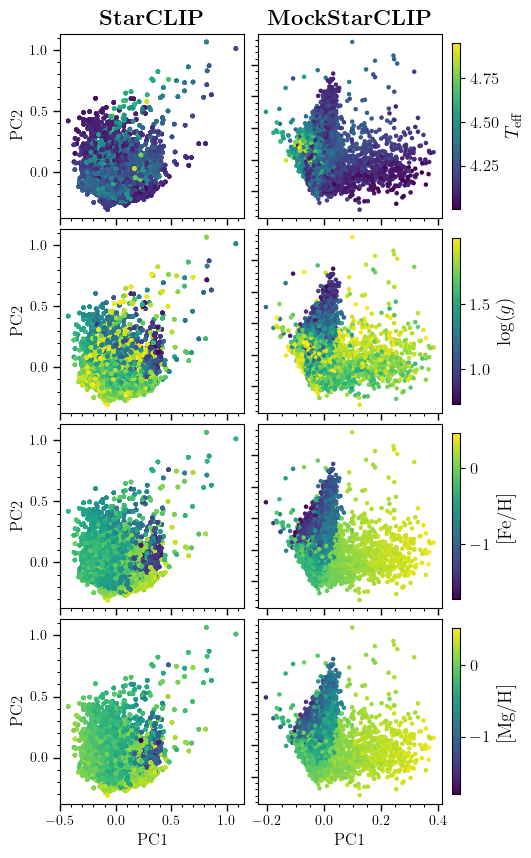

In [96]:
## Create PCA plots ## 
def apply_and_plot_pca_side_by_side(feature_sets1, labels1, test_indices1, model_name1,
                                     feature_sets2, labels2, test_indices2, model_name2,
                                     n_components=2, output_dir="FIGURES", label_names=None):
    """
    Combines two feature sets, applies PCA, and plots the results side by side using GridSpec.
    Also prints the variance explained by the first two principal components for each model.
    """
    # Combine feature sets
    combined_features1 = pd.concat([pd.DataFrame(f) for f in feature_sets1], axis=0)
    combined_features2 = pd.concat([pd.DataFrame(f) for f in feature_sets2], axis=0)

    # Apply PCA to each combined feature set
    pca1 = PCA(n_components=n_components)
    pca_results1 = pca1.fit_transform(combined_features1)

    pca2 = PCA(n_components=n_components)
    pca_results2 = pca2.fit_transform(combined_features2)

    # Explained variance ratios
    var_ratio1 = pca1.explained_variance_ratio_
    var_ratio2 = pca2.explained_variance_ratio_

    print(f"[{model_name1}] PC1 explains {var_ratio1[0]:.2%} of variance, PC2 explains {var_ratio1[1]:.2%}")
    print(f"[{model_name2}] PC1 explains {var_ratio2[0]:.2%} of variance, PC2 explains {var_ratio2[1]:.2%}")

    # Plotting setup
    fig = plt.figure(figsize=(12, 10))
    gs = gridspec.GridSpec(4, 2, figure=fig, hspace=0.058, wspace=-1.041)

    selected_indices = [0, 1, 16, 6]  # columns in label dataframe
    axs = [[fig.add_subplot(gs[i, j]) for j in range(2)] for i in range(4)]

    for idx, i in enumerate(selected_indices):
        for col, (pca_results, labels, test_indices, model_name) in enumerate(
                [(pca_results1, labels1, test_indices1, model_name1),
                 (pca_results2, labels2, test_indices2, model_name2)]):
            
            sc = axs[idx][col].scatter(pca_results[:, 0], pca_results[:, 1],
                                       c=labels.iloc[test_indices][labels.columns[i]].values, s=5)
            axs[idx][col].set_box_aspect(1)

            if col == 1:
                cbar = plt.colorbar(sc, ax=axs[idx][col], shrink=0.9, pad=0.01)
                label = label_names[i] if label_names else labels.columns[i]
                cbar.set_label(label=f"{label}", size=14)
                cbar.ax.tick_params(labelsize=12)

            if idx == 3:
                axs[idx][col].set_xlabel("PC1", fontsize=12)
            if col == 0:
                axs[idx][col].set_ylabel("PC2", fontsize=12)

            axs[idx][col].xaxis.set_minor_locator(AutoMinorLocator())
            axs[idx][col].yaxis.set_minor_locator(AutoMinorLocator())
            axs[idx][col].tick_params(axis='both', which='major', length=5, width=1)
            axs[idx][col].tick_params(axis='both', which='minor', length=2.5, width=0.8)

            if idx != 3:
                axs[idx][col].set_xticklabels([])
            if col != 0:
                axs[idx][col].set_yticklabels([])

            if idx == 0:
                axs[idx][col].set_title(f"$\\mathbf{{{model_name}}}$", fontsize=16)

            axs[idx][col].grid(False)

    # Save figure
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    save_path = os.path.join(output_dir, "StarCLIP_vs_MockStarCLIP_pca_subplot.png")
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
apply_and_plot_pca_side_by_side(
    [y_j_test, y_a_test], aug_jwst_labels_twice, test_indices_twice, "StarCLIP",
    [y_js_test, y_mjs_test], mock_jwst_labels_twice, mock_test_indices_twice, "MockStarCLIP",
    label_names=label_names  # optionally pass label names if defined
) 

## **7. References** <a class="anchor" id="refs"></a>

**Literature** 
Parker, L., Lanusse, F., Golkar, S., Sarra, L., Cranmer, M., Bietti, A., Eickenberg, M., Krawezik, G., McCabe, M., Morel, R., Ohana, R., Pettee, M., Régaldo-Saint Blancard, B., Cho, K., & Ho, S. (2024). "AstroCLIP: A cross-modal foundation model for galaxies." *Monthly Notices of the Royal Astronomical Society*, 531(4), 4990–5011. https://doi.org/10.1093/mnras/stae1450 

**Code** 
https://github.com/PolymathicAI/AstroCLIP/blob/neurips23/notebooks/tutorial/AstroCLIPTutorial.ipynb 